In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import calendar
import datetime as dt
plt.style.use('seaborn')

C:\Users\alanv\AppData\Local\Temp\ipykernel_24864\3477585234.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
i_tickers=pd.read_excel('SeriesInflation_ids.xlsx',index_col=0)

In [4]:
series=i_tickers.Serie.to_list()

In [5]:
API = '4f988b8a-9fe0-8498-a864-7d45e96af34f'
def get_BIE(serie, API ,historic='false'):
    
    if isinstance(serie, int):
        serie=str(serie)
    
    url='https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/'+serie+'/es/0700/'+historic+'/BIE/2.0/'+API+'?type=json'
    response = requests.get(url)
    if response.status_code == 200:
        content = json.loads(response.content)
        observations=content['Series'][0]['OBSERVATIONS']
        try:
            obs=[]
            dates=[]
            for i in observations:
                if i['OBS_VALUE'] == '':
                    value=np.nan
                else:    
                    value=float(i['OBS_VALUE'])
                    
                obs.append(value)
                dates.append(i['TIME_PERIOD'])            
            df=pd.DataFrame({'Serie':obs},index=dates)
            index=pd.to_datetime(df.index,format='%Y/%m')
            df.index=[dt.date(y,m, calendar.monthrange(y, m)[1]) for y,m in zip(index.year,index.month)]
            df.sort_index(inplace=True)
        except:
            print('Error with '+serie)
    else:        
        print('Error with the response')
    return df

In [6]:
inflation_data=pd.DataFrame()
for serie in series:    
    df=get_BIE(serie, API ,historic='false')
    inflation_data=pd.concat([inflation_data,df],axis=1)
inflation_data.columns=i_tickers.index
inflation_data.index=pd.to_datetime(inflation_data.index,format='%Y-%m-%d')

### Ponderadores

In [7]:
ponderadores = pd.read_excel('ponderadores.xlsx', index_col=0, skiprows=9, sheet_name='ObjetoGasto')

In [8]:
ponderadoresFinal={}
ponderadores100={}
for rubro in ponderadores.columns[1:]:
    pesos=ponderadores[['INPC',rubro]]
    pesos=pesos[pesos[rubro]=='X']
    pesos=pesos[['INPC']]#.drop(['Total'],axis=0)
    pesos=pesos/100
    ponderadoresFinal[rubro] = pesos['INPC']
    ponderadores100[rubro] = pesos['INPC']/pesos['INPC'].sum()
    print(rubro,' ', float((pesos/pesos.sum()).sum().values))

IndiceGeneral   1.0
Total_Subyacente   1.0
Total_Mercancias_Subyacente   1.0
AlimentosBebidasTabaco_Mercancias_Subyacente   0.9999999999999999
NoAlimenticias_Mercacias_Subyacente   1.0
Total_Servicios   1.0000000000000004
Educacion_Servicios_Subyacente   0.9999999999999998
Vivienda_Servicios_Subyacente   1.0
Otros_Servicios_Subyacente   1.0000000000000002
Total_NoSubyacente   1.0
Total_Agropecuarios_NoSubyacente   1.0
FrutasVerduras_Agropecuarios_NoSubyacente   1.0000000000000004
Pecuarios_Agropecuarios_NoSubyacente   1.0
EnergeticosTarifasGobierno_Total_NoSubyacente   0.9999999999999999
Energeticos_EnergeticosTarifasGobierno_NoSubyacente   1.0
Tarifas_EnergeticosTarifasGobierno_NoSubyacente   1.0
SubIndice   1.0


In [9]:
finalData=pd.DataFrame()
for ids in ponderadores.index.to_list():#[:-1]:
    o=inflation_data[[ids]]
    if len(o.columns)>1 : o=o.iloc[:,0]
    finalData=pd.concat([finalData,o],axis=1)    
finalData.index=pd.to_datetime(finalData.index,format='%Y-%m-%d')

In [10]:
finalData.to_excel('RelevantInflation.xlsx')
inflation_data.to_excel('FullInflation.xlsx')

In [11]:
finalData=finalData.loc['2000':]

In [12]:
finalData.index=finalData.index.strftime("%Y-%b")

### Analisis

In [13]:
dataSubset={}
inflation2={}
MoMcontribution={} # MoM Changes
YoYcontribution={} # YoY Changes 
for key in ponderadores100.keys(): #ponderadores en base 100
    pesos=ponderadores100[key] #Extraemos los pesos
    items=pesos.index.to_list()
    data=finalData[items]
    dataSubset[key]=data
    
    #YoY
    YoYcontribution[key]=(data.pct_change(12) * pesos).T
    MoMcontribution[key]=(data.pct_change().fillna(0) * pesos).T

In [14]:
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std().shift(1)
    z = (x-m)/s
    return z

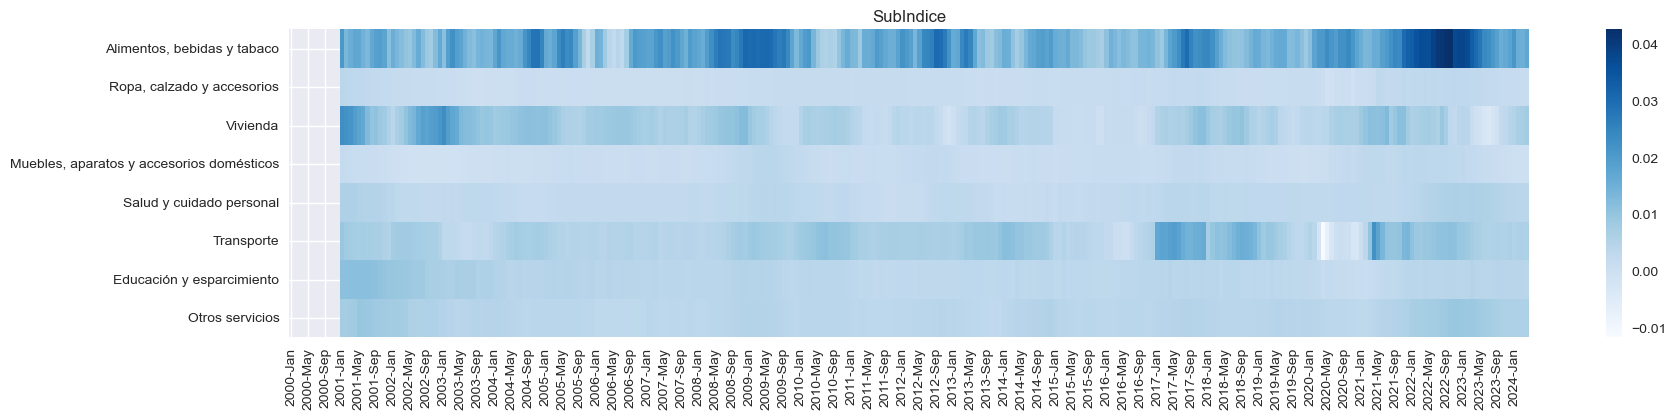

In [15]:
data=YoYcontribution['IndiceGeneral']
plt.figure(figsize=(20,4))
sns.heatmap(data, cmap='Blues')
plt.title(key)
plt.show()

In [16]:
from scipy.stats import percentileofscore
def percentilScore(df, method='weak'):
    '''This function calculate the percentile where the last data point is relative to a series '''
    percentiles=[]
    for col in df.columns:
        x = percentileofscore(df[col],df[col].iloc[-1],method)/100
        percentiles.append(x)
    ret_val=pd.DataFrame(percentiles,index=df.columns)
    return ret_val


In [17]:
def percentiles(x):
    results=pd.DataFrame()
    for i,idx in enumerate(x.columns[:-12]):
        filterData=x.T.iloc[i:(i+12)]
        filterData.fillna(0,inplace=True)
        percs=percentilScore(filterData)
        percs=percs[0].sort_values(ascending=True)
        percs.index=np.arange(0,len(percs))
        results=pd.concat([results,percs],axis=1)        
    results.columns=x.columns[12:]
    return results

In [26]:
data=YoYcontribution[key]

def percentiles_hist(data):
    results=pd.DataFrame()
    for item in data.index:
        percentiles=(data.loc[item].dropna().rank()/len(data.loc[item].dropna()))
        results=pd.concat([results,percentiles],axis=1)

    final_result=pd.DataFrame()
    for date in results.loc['2018-Jan':].index:
        preliminar=results.loc['2018-Jan':].loc[date].fillna(0).sort_values()
        preliminar.index=np.arange(0,len(preliminar.index),1)
        final_result=pd.concat([final_result,preliminar],axis=1)
    return results, final_result

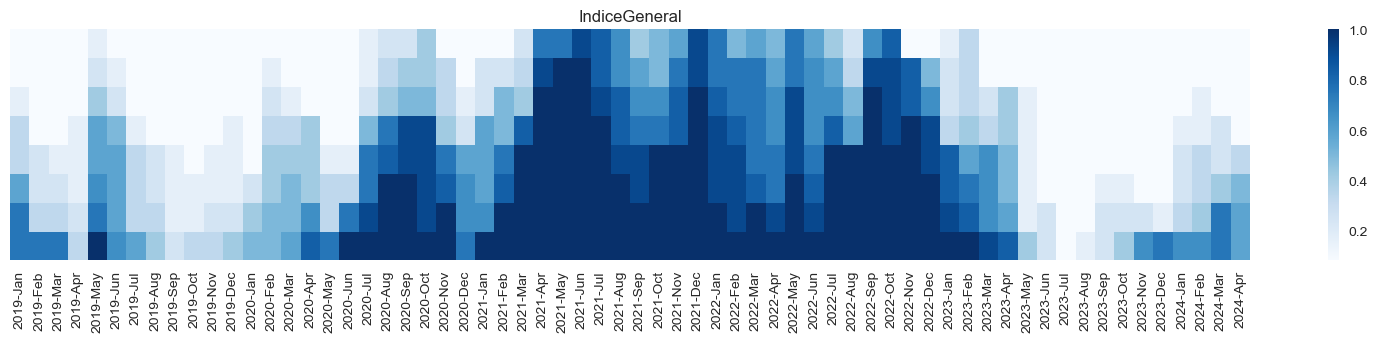

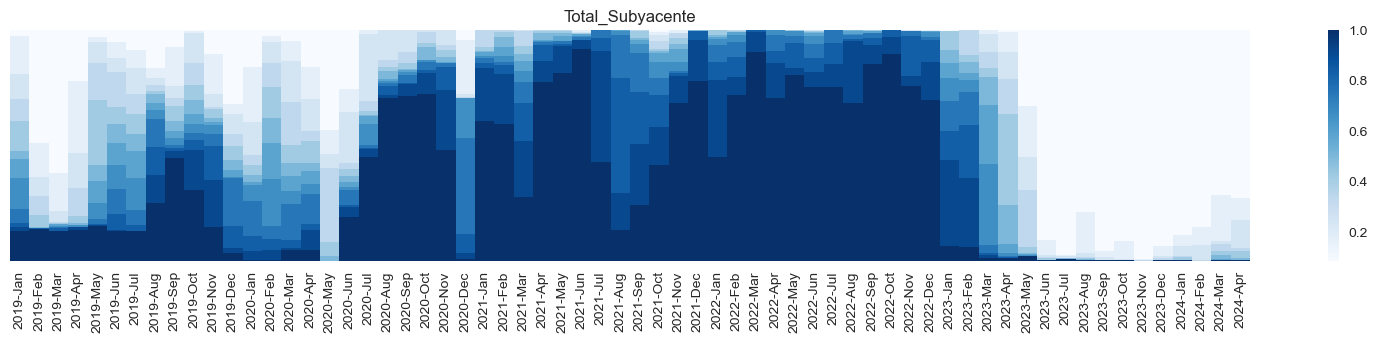

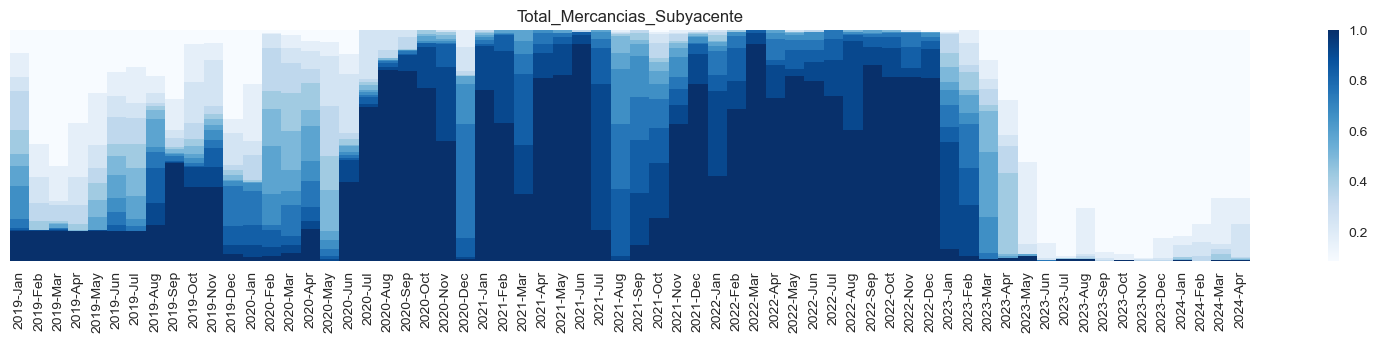

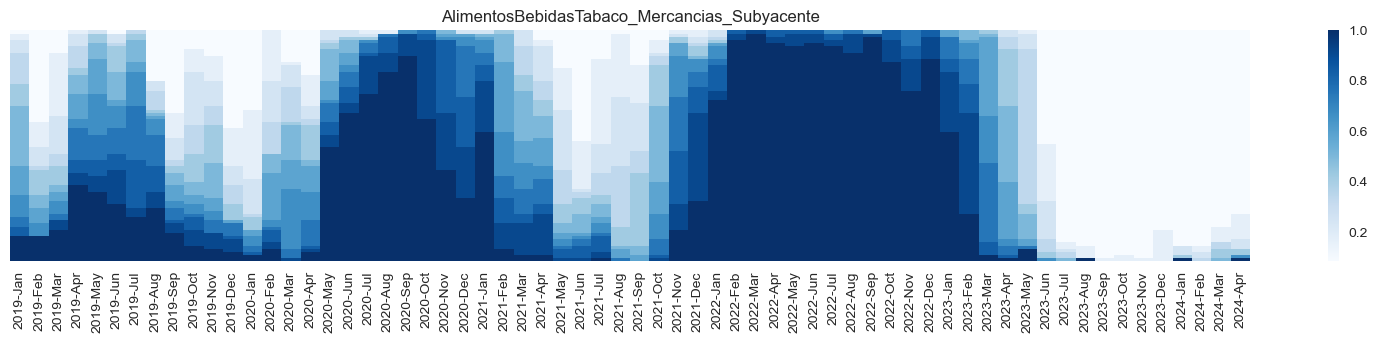

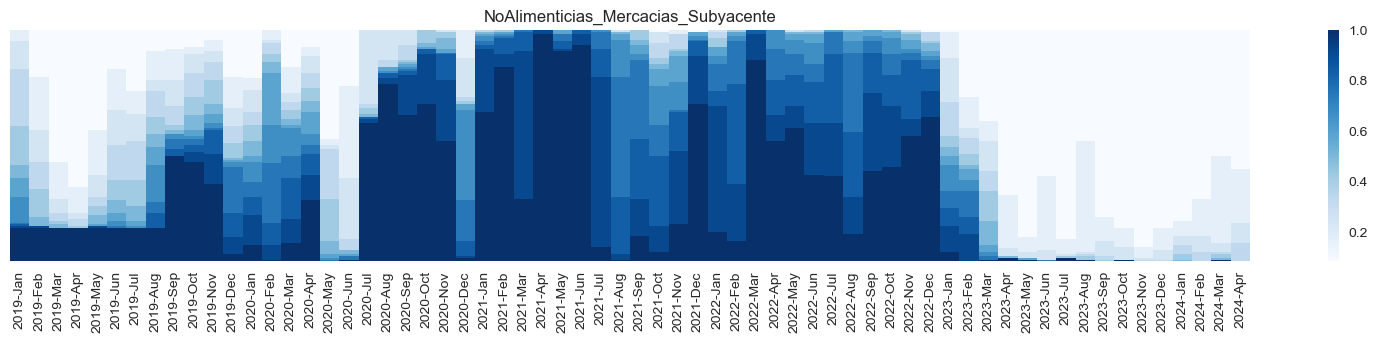

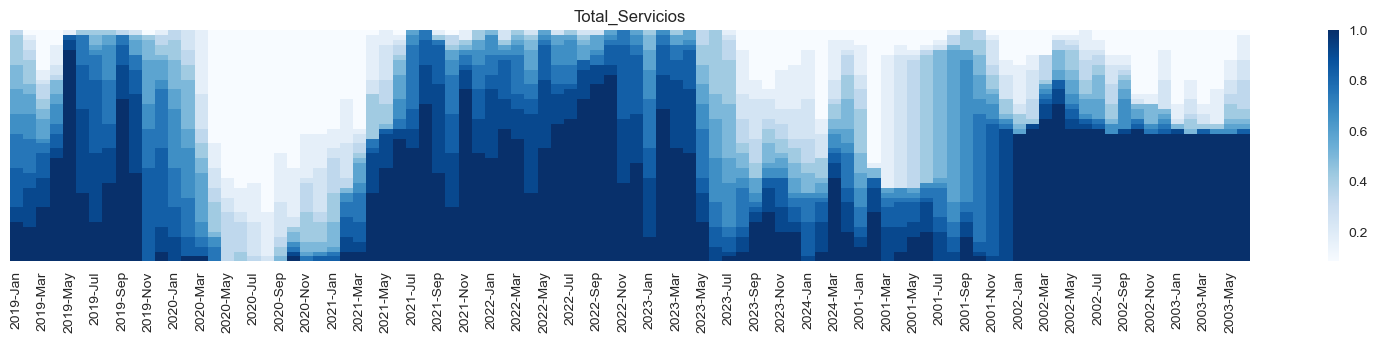

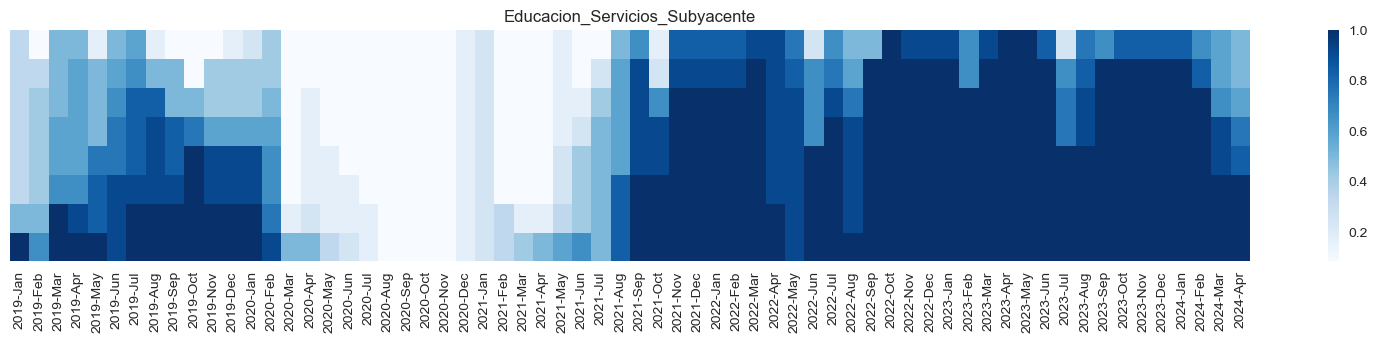

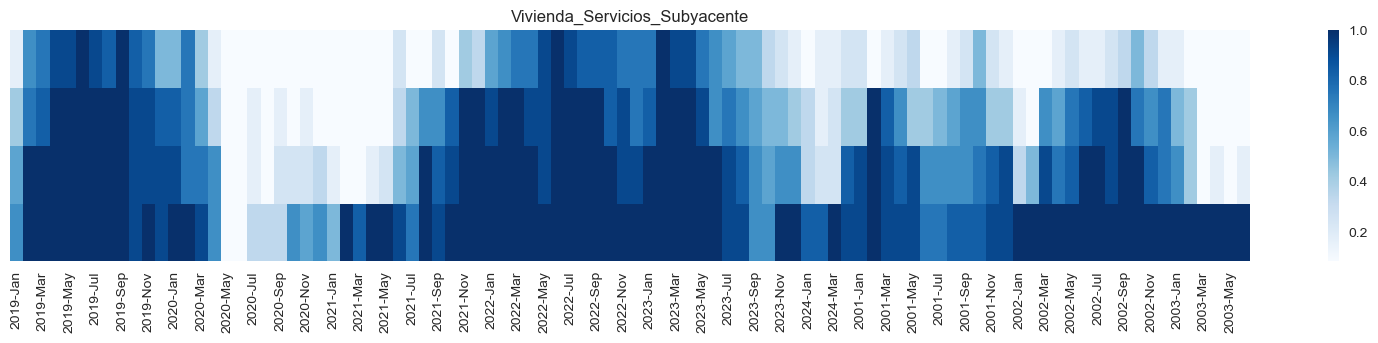

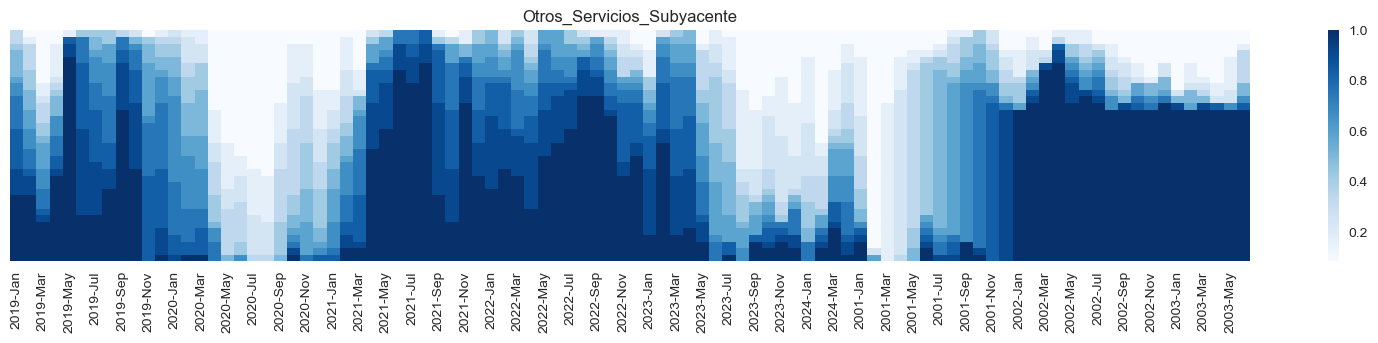

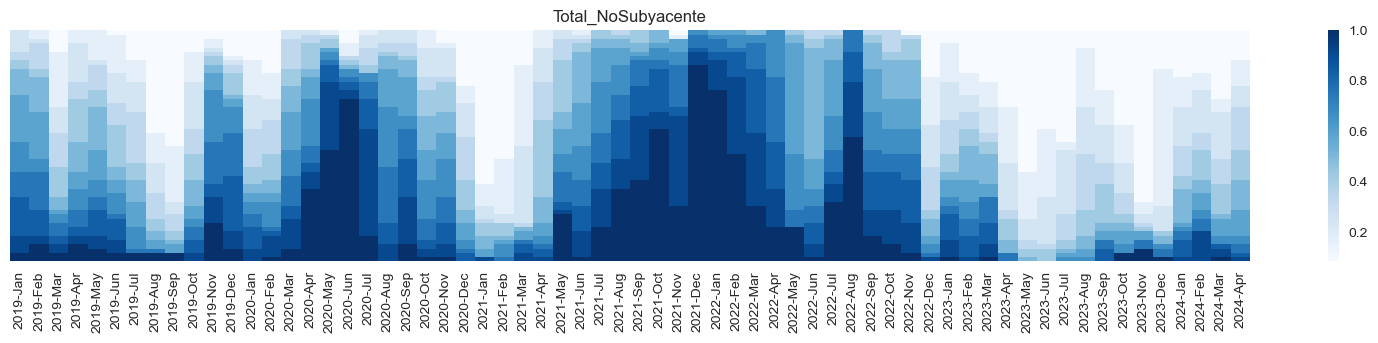

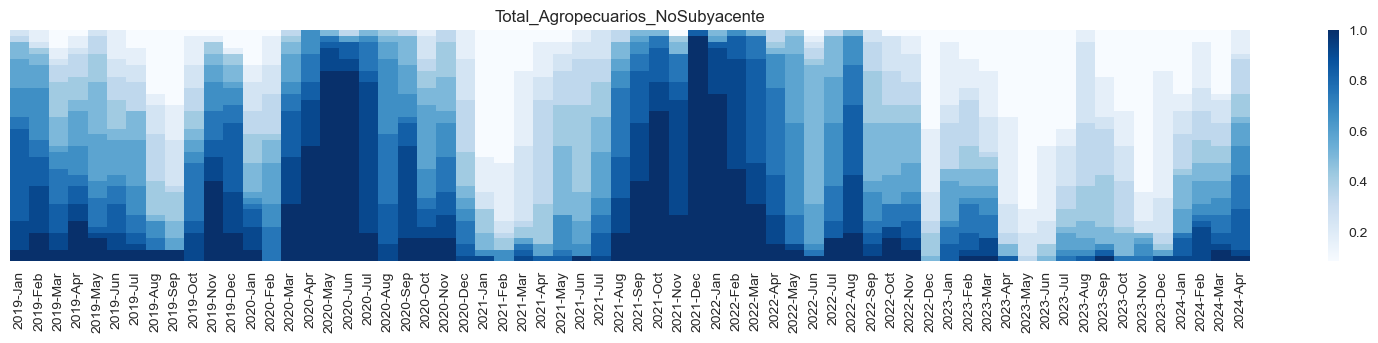

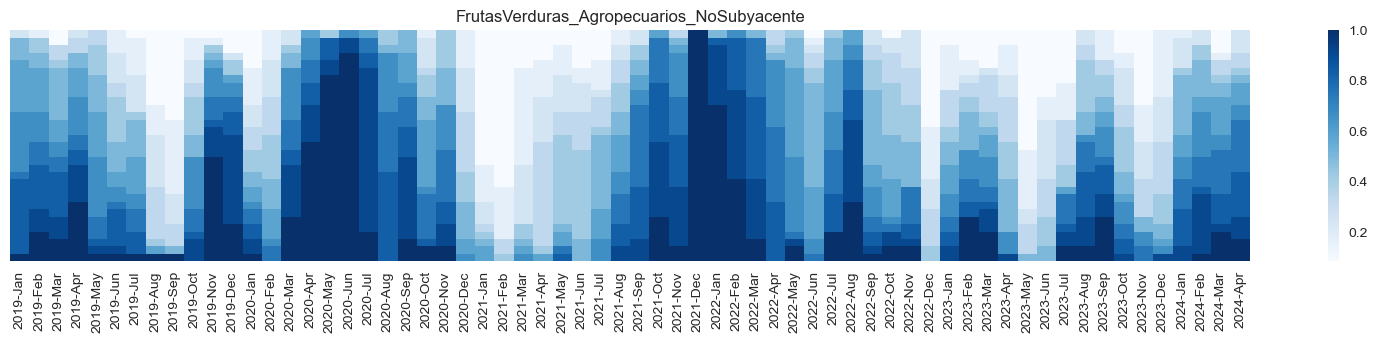

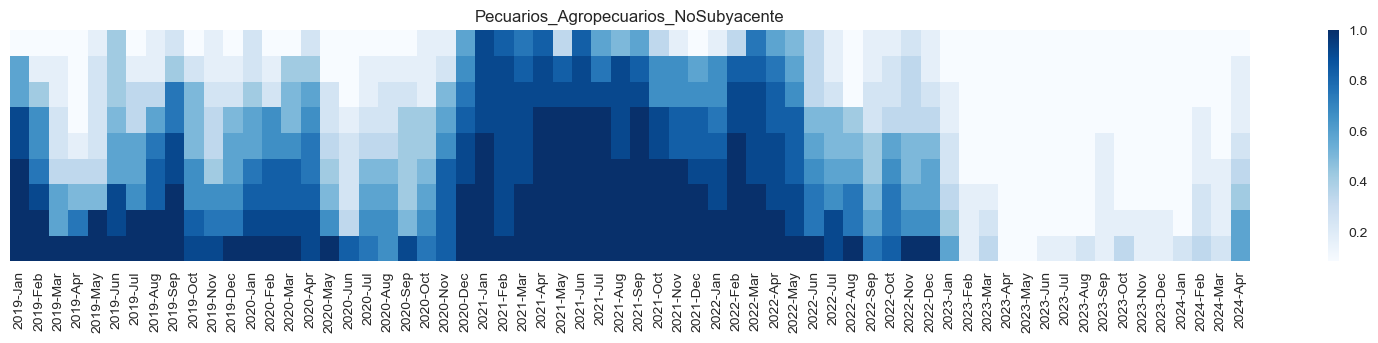

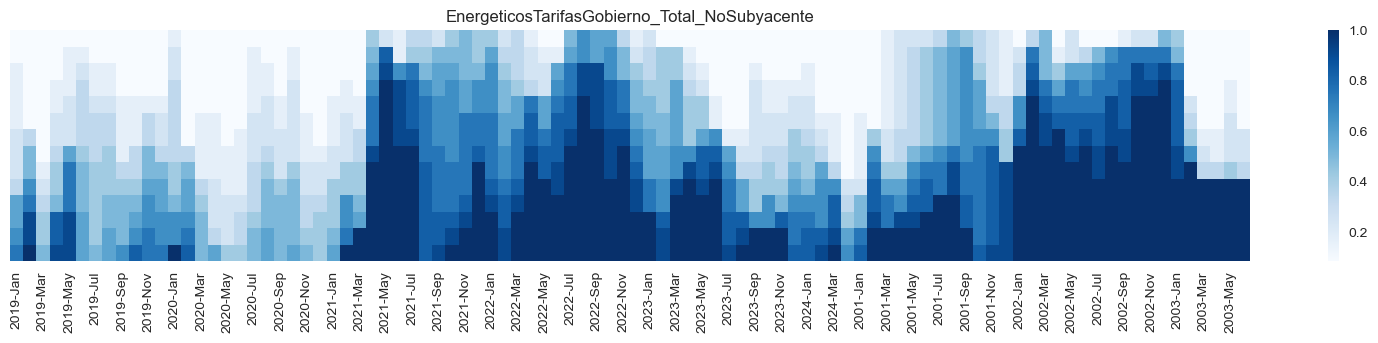

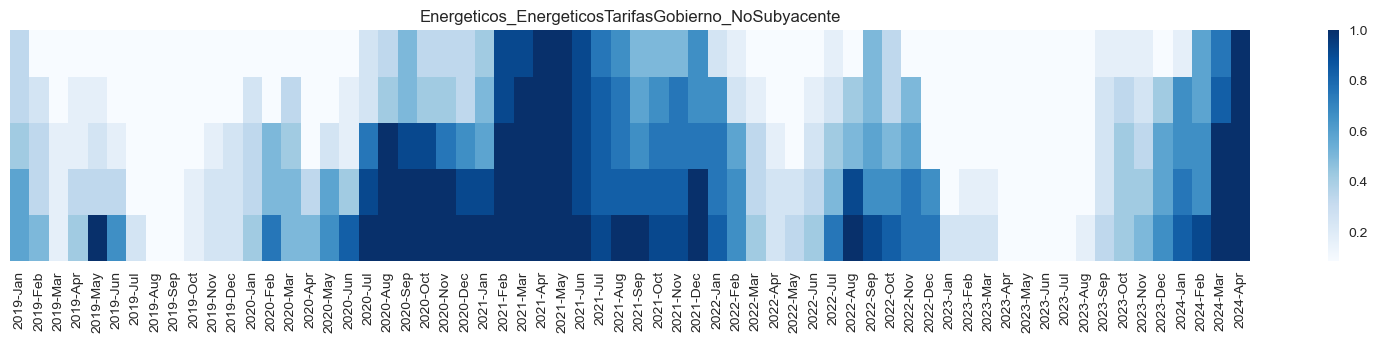

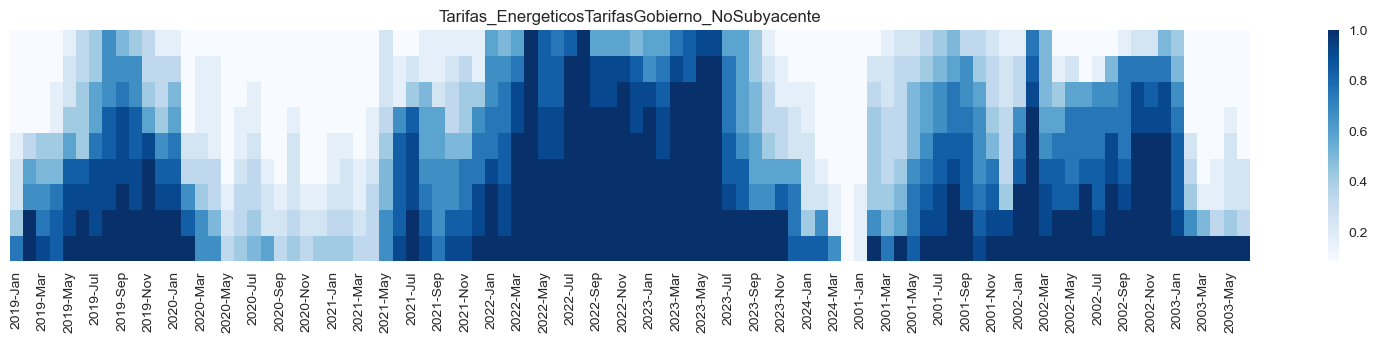

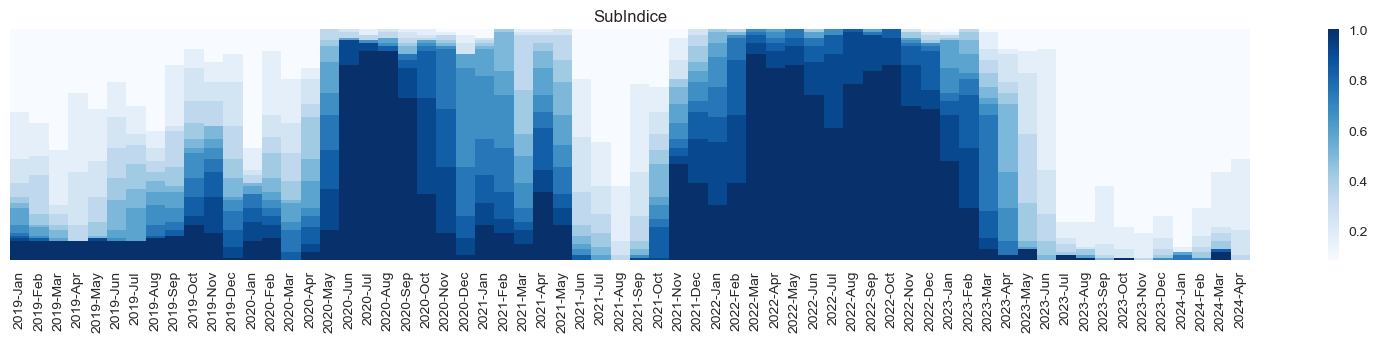

In [31]:
for key in YoYcontribution.keys():
    data=YoYcontribution[key]
    full_percentiles, sample_percentiles = percentiles_hist(data)
    perc=percentiles(sample_percentiles)
    plt.figure(figsize=(20,3))
    sns.heatmap(perc, cmap='Blues')
    plt.title(key)
    plt.yticks([])
    plt.grid(True)
    plt.show()

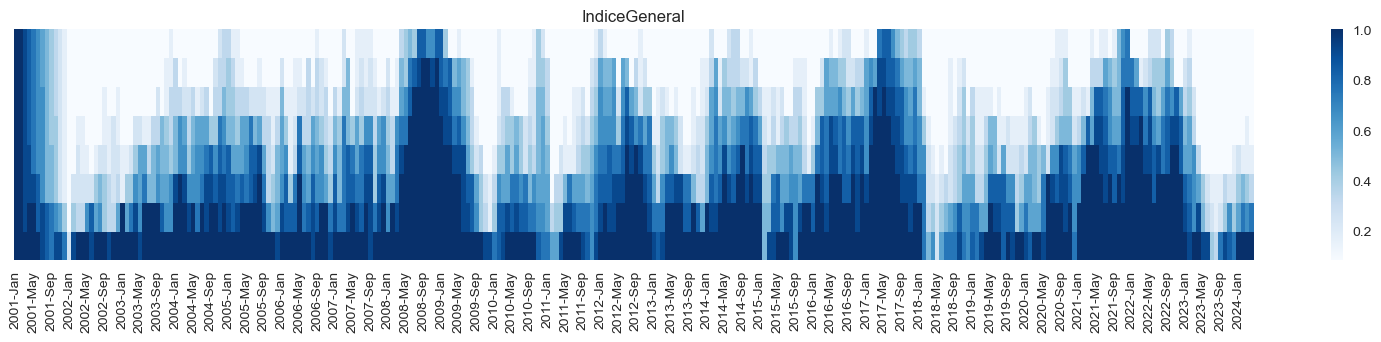

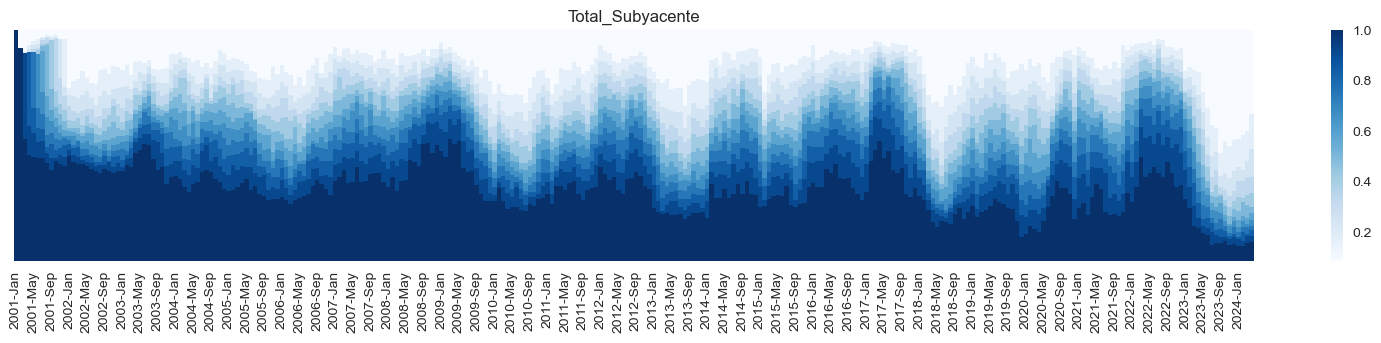

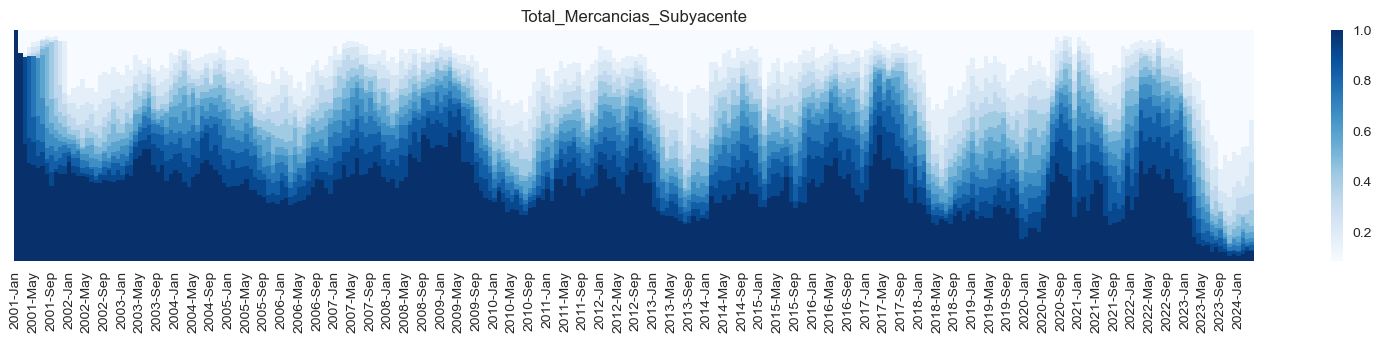

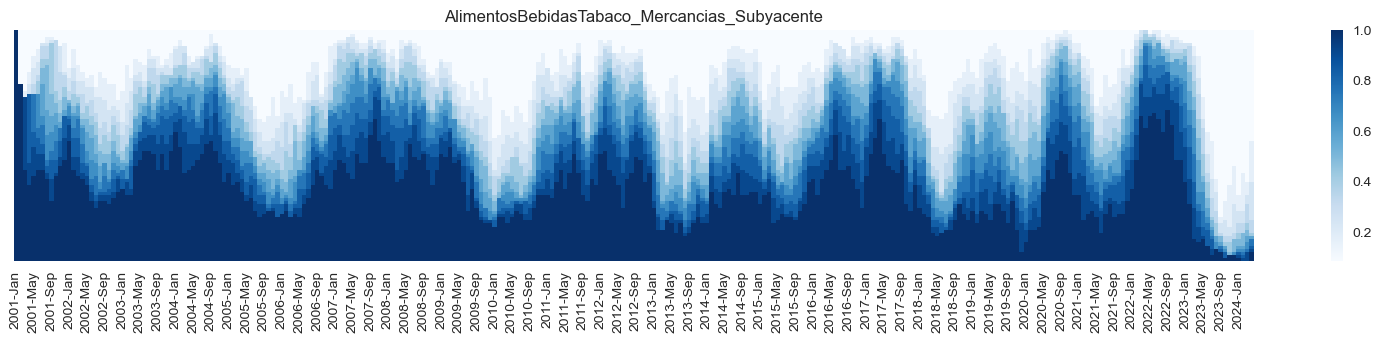

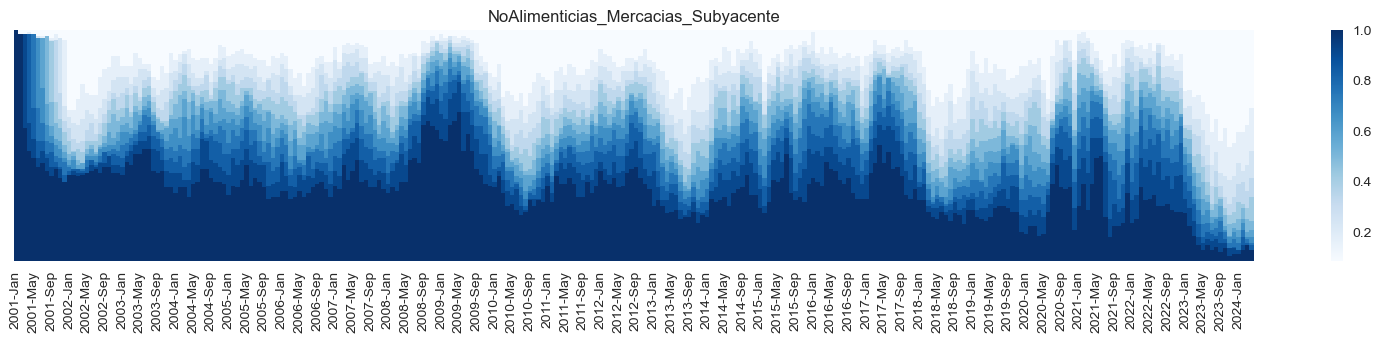

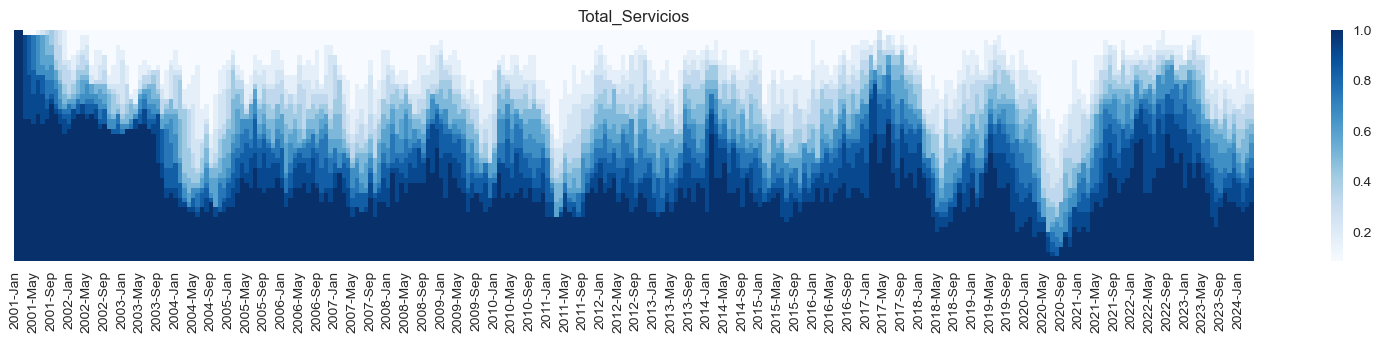

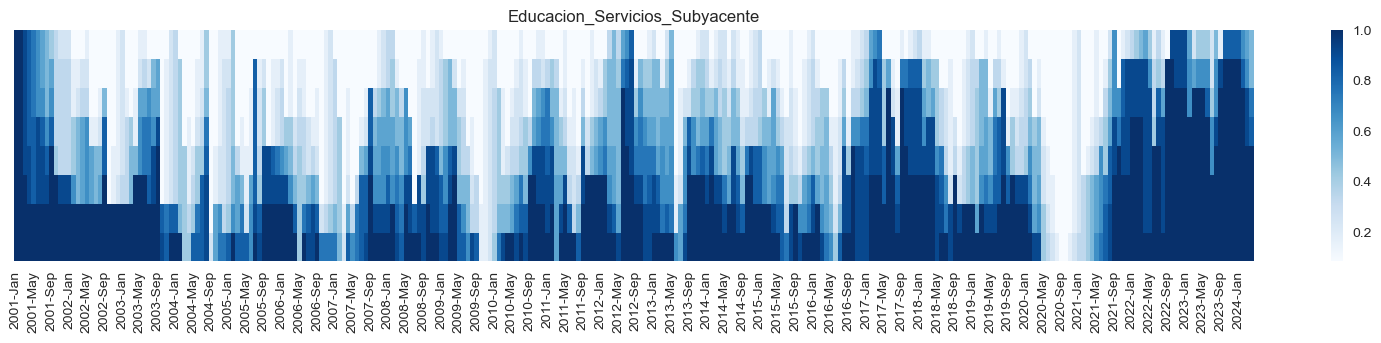

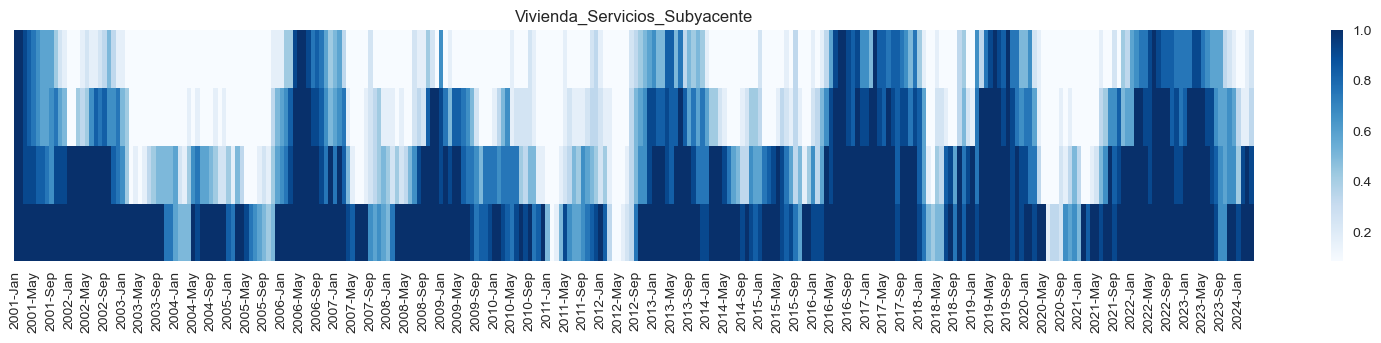

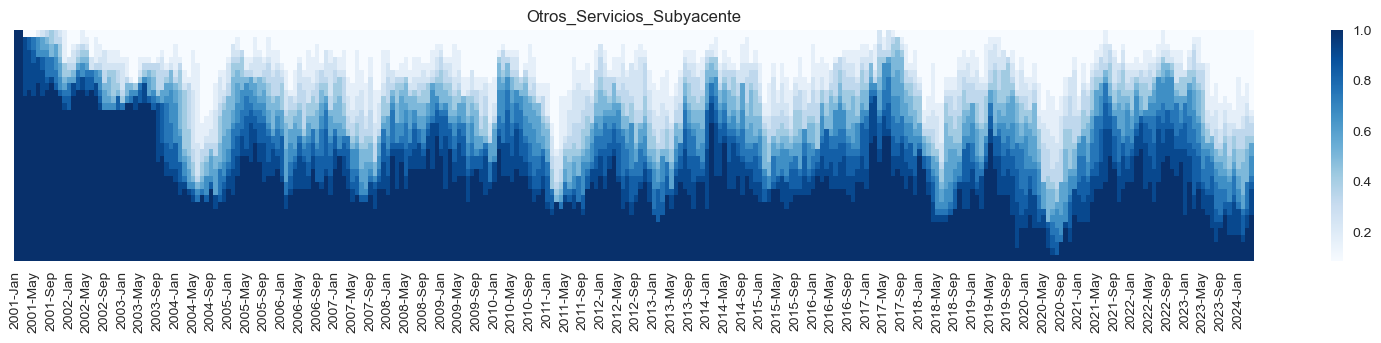

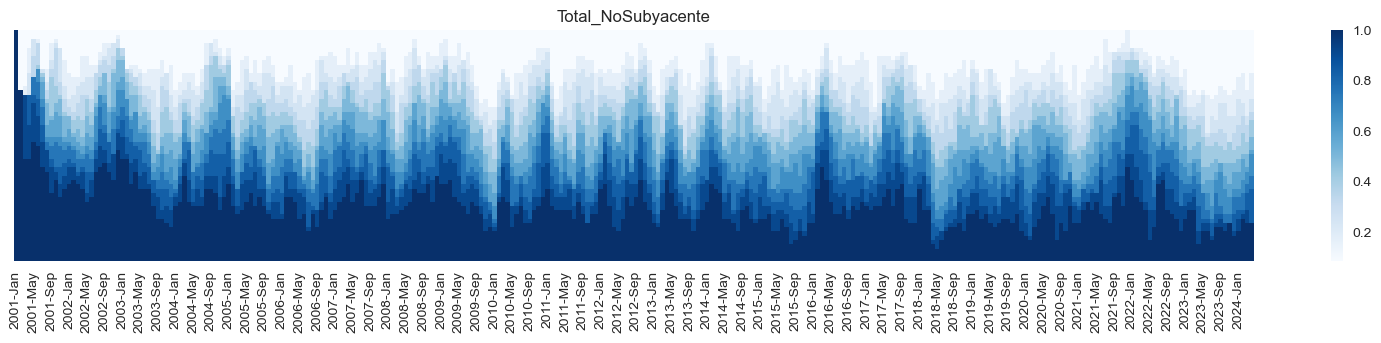

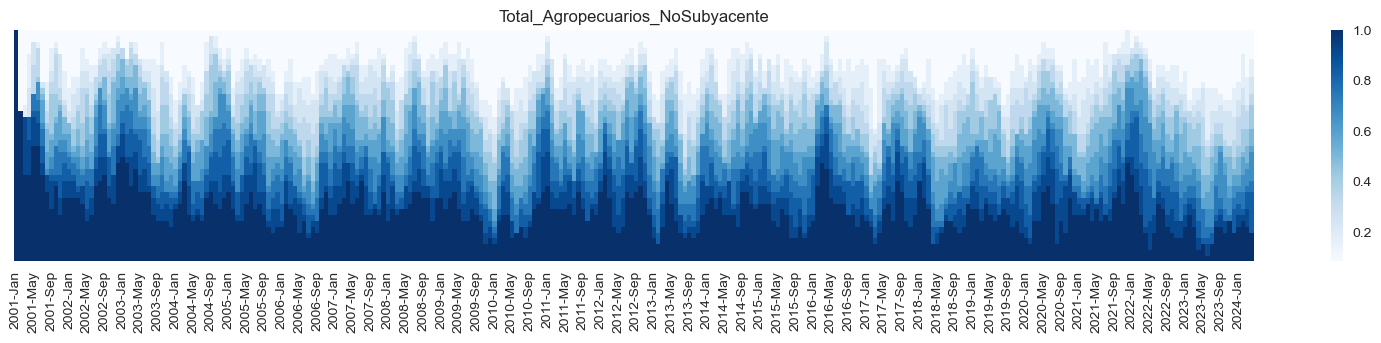

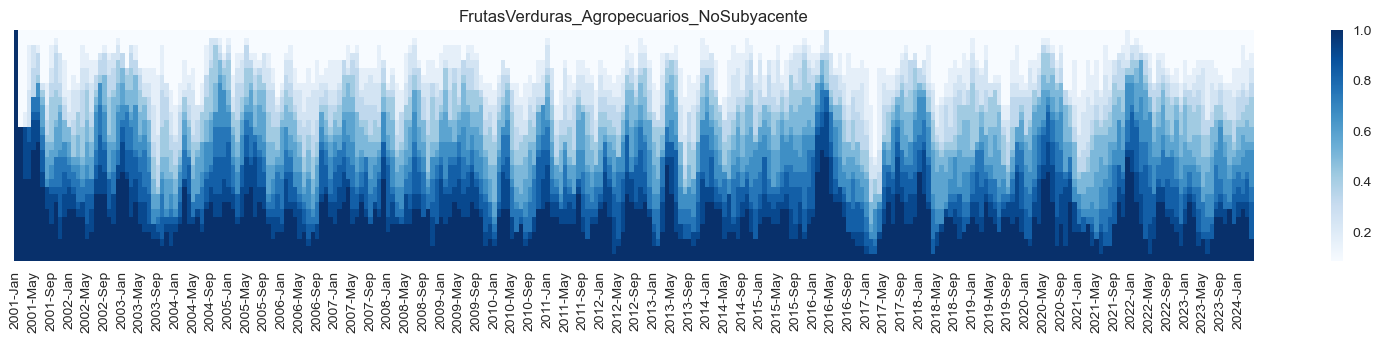

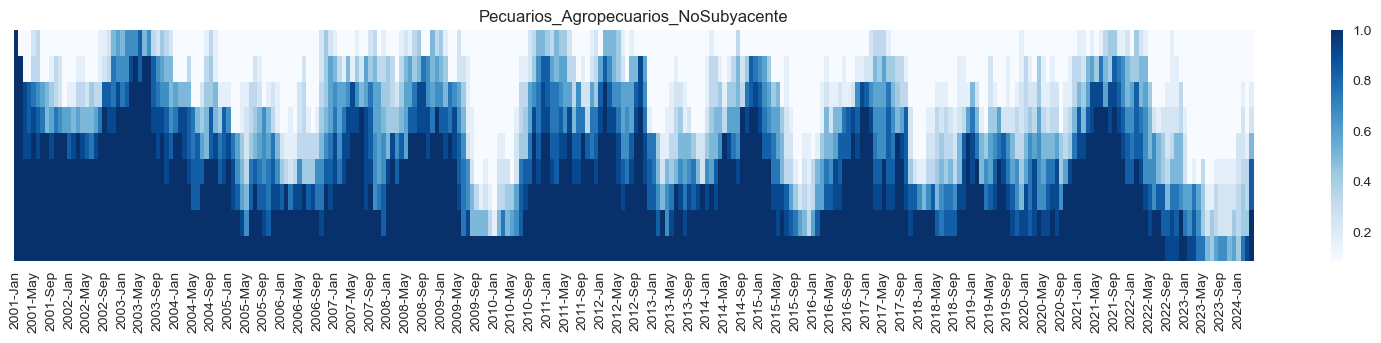

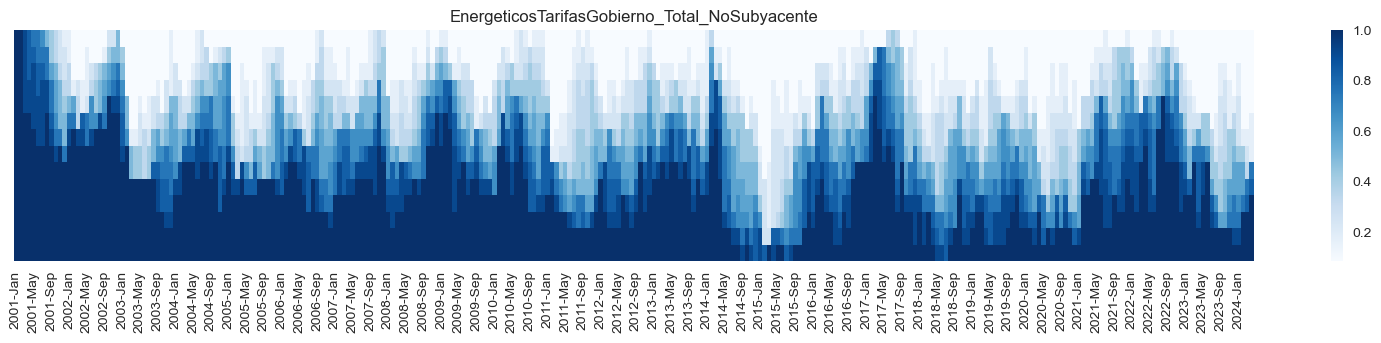

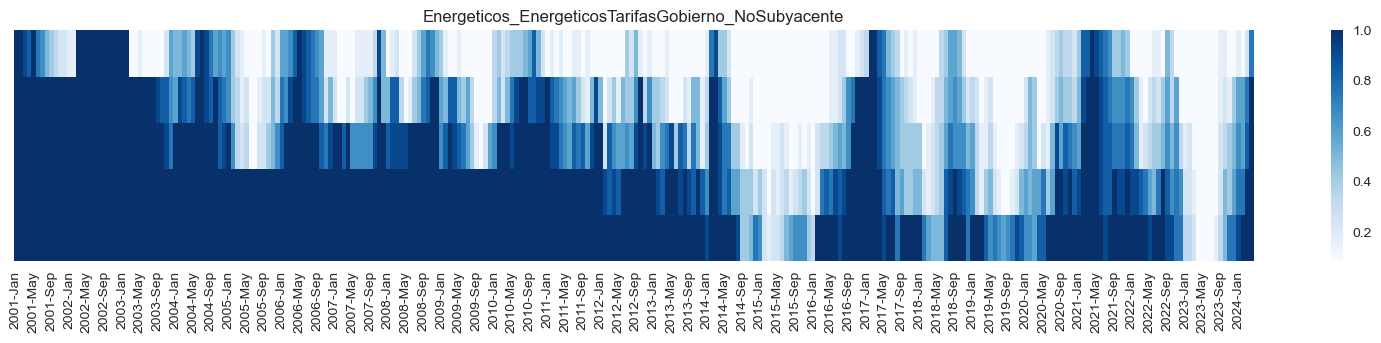

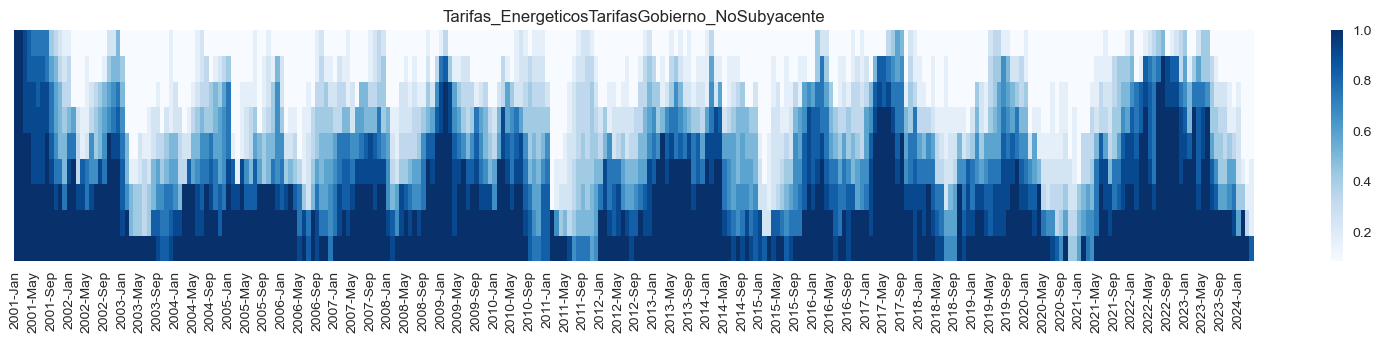

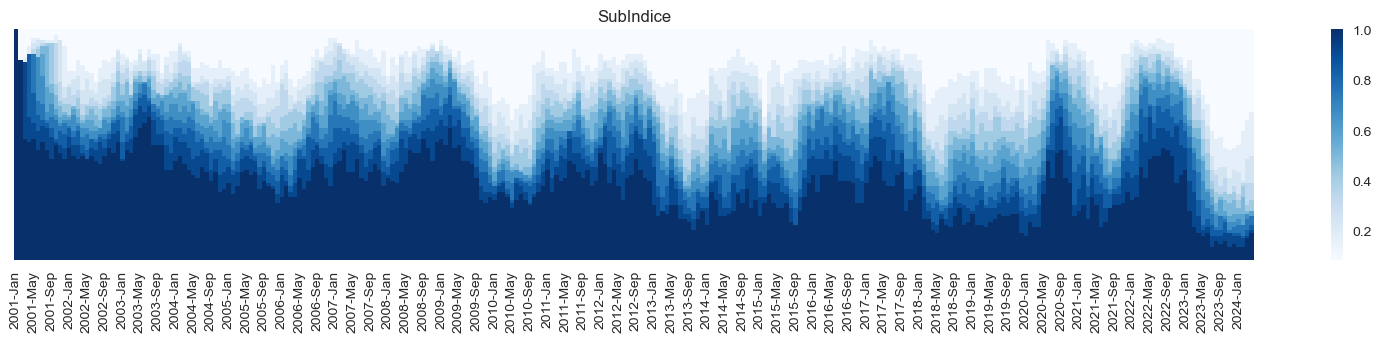

In [32]:
for key in YoYcontribution.keys():
    data=YoYcontribution[key]
    perc=percentiles(data)
    plt.figure(figsize=(20,3))
    sns.heatmap(perc, cmap='Blues')
    plt.title(key)
    plt.yticks([])
    plt.grid(True)
    plt.show()

In [33]:
items_all=ponderadoresFinal['IndiceGeneral'].index.to_list()
selected=ponderadores['INPC'].index.to_list()
componentes=[ponderador for ponderador in selected[1:] if ponderador not in items_all]
pesosGenerales=ponderadores.loc[componentes,'INPC']
allItems=pesosGenerales.index.to_list()

In [34]:
items=pd.DataFrame()
for col in allItems:
    _=finalData[[col]]
    if len(_.columns)>1 : _=_.iloc[:,0]
    items=pd.concat([items,_],axis=1)

In [35]:
itemsYoY=items.pct_change(12).loc['2018-Jan':]
inflationGranular=(itemsYoY*pesosGenerales)

In [36]:
inflationGranular.iloc[-1]

Aceites y grasas vegetales comestibles      -0.018535
Agua embotellada                             0.042088
Aguacate                                     0.049860
Alimentos para bebé                          0.002546
Arroz                                        0.011392
                                               ...   
Loncherías, fondas, torterías y taquerías    0.363063
Paquetería                                   0.000779
Restaurantes y similares                     0.177880
Servicios funerarios                         0.011352
Servicios profesionales                      0.016898
Name: 2024-Apr, Length: 299, dtype: float64

In [37]:
data=inflationGranular.iloc[-1].sort_values(ascending=False)
data=data[data!=0]
size=len(data.index)
size=10 #round(size*.1)
most=data.index[:size].to_list()
least=data.index[-size:].to_list()

In [38]:
incidents=pd.concat([data[most],data[least]],axis=0)
asTotal=incidents/data.sum()
incidents=pd.concat([incidents,asTotal],axis=1)
incidents.columns=['Contributions','100']
incidents=incidents.sort_values(by='100',ascending=False)

In [39]:
mostLeast=most+least
classification=['Green' if x in ponderadores100['Total_Subyacente'].index.to_list() else 'Blue' for x in mostLeast] 

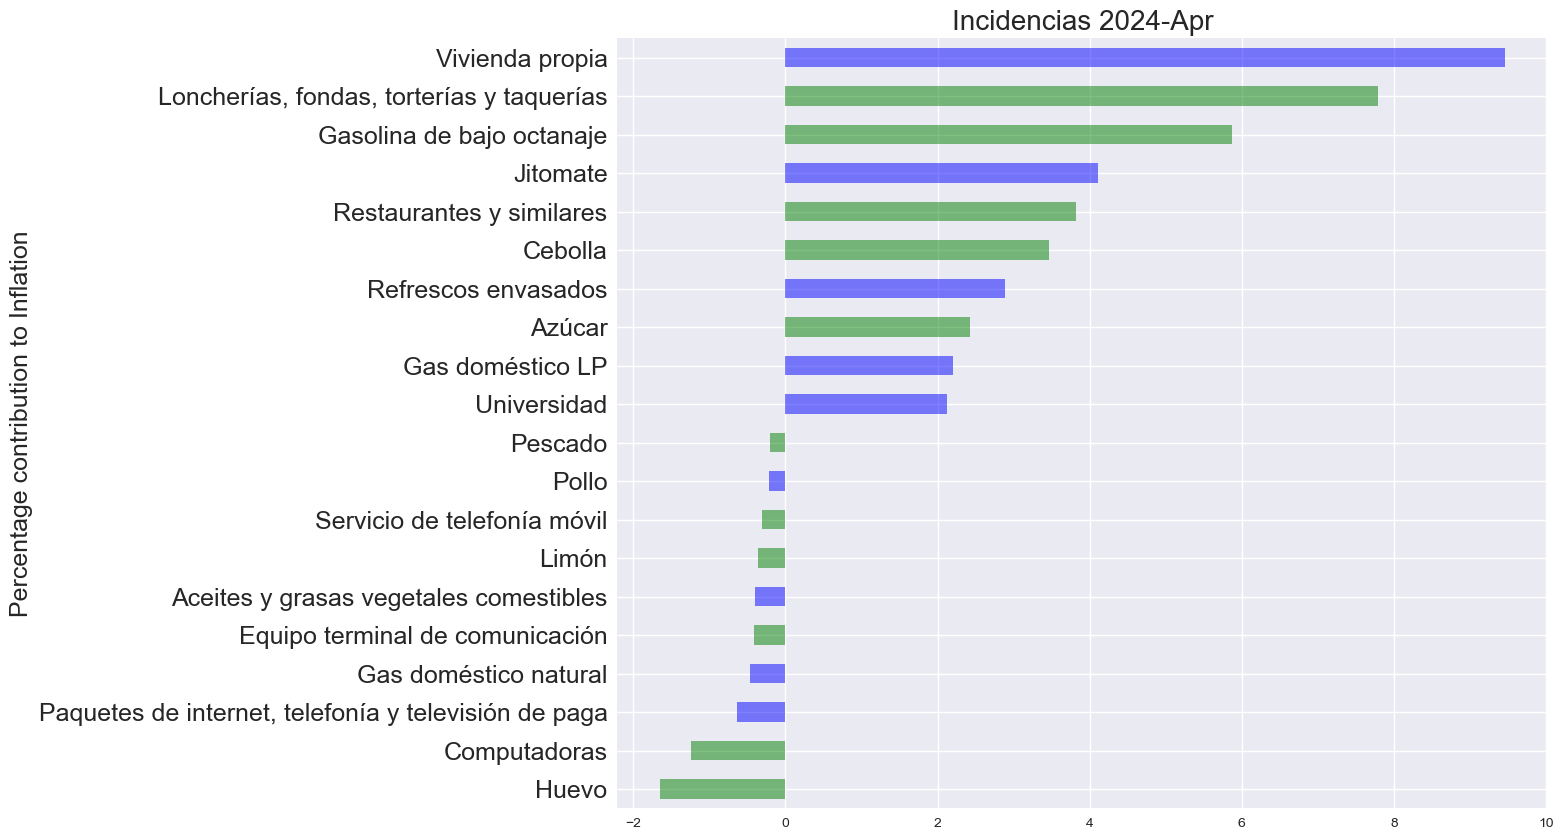

In [41]:
(100*incidents['100'].sort_values(ascending=True)).plot.barh(figsize=(12,10), title=key,color=classification,alpha=0.5)
plt.title('Incidencias '+inflationGranular.iloc[-1].name, fontdict = {'fontsize' : 20})
plt.ylabel('Percentage contribution to Inflation', size=18)
plt.yticks(size=18)
plt.show()

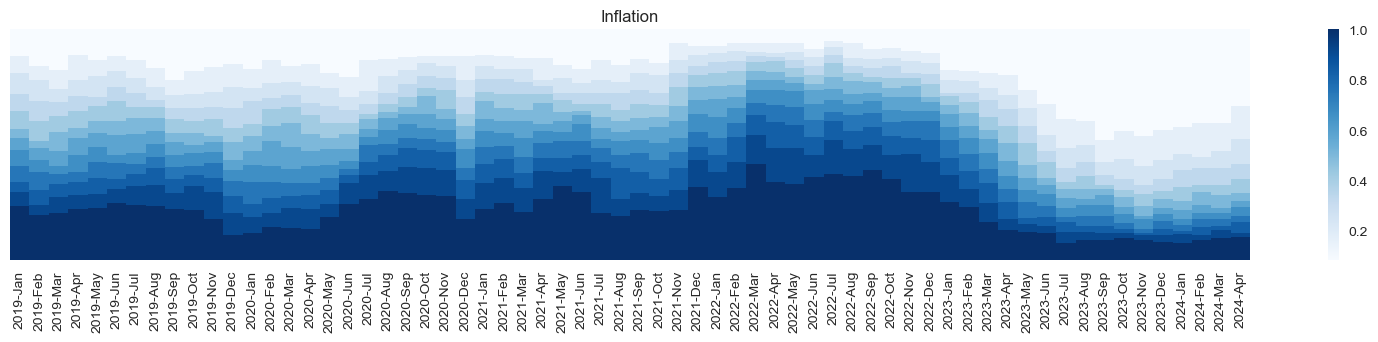

In [42]:
perc=percentiles(inflationGranular.T)
plt.figure(figsize=(20,3))
sns.heatmap(perc, cmap='Blues')
plt.title('Inflation')
plt.yticks([])
plt.grid(True)
plt.show()

### Contributions - Goods & Services in Core Inflation

In [43]:
core_weight=ponderadores['Total_Subyacente']['IndiceGeneral']

In [44]:
goods=ponderadores['Total_Mercancias_Subyacente']['IndiceGeneral']
services=ponderadores['Total_Servicios']['IndiceGeneral']

In [45]:
goods_weight=goods/core_weight
services_weight=services/core_weight

In [46]:
goods_list=ponderadores[['INPC','Total_Mercancias_Subyacente']][ponderadores['Total_Mercancias_Subyacente']=='X']['INPC']
goods_list_100=goods_list/goods_list.sum()
goods_w_contribution=goods_list_100 * goods_weight

In [47]:
services_list=ponderadores[['INPC','Total_Servicios']][ponderadores['Total_Servicios']=='X']['INPC']
services_list_100=services_list/services_list.sum()
services_w_contribution=services_list_100 * services_weight

In [48]:
YoY_change=finalData[goods_list_100.index].pct_change(12)
goods_contribution_core=(YoY_change.loc['2018-Jan':] * goods_w_contribution).sum(axis=1)

In [49]:
YoY_change=finalData[services_list_100.index].pct_change(12)
services_contribution_core=(YoY_change.loc['2018-Jan':] * services_w_contribution).sum(axis=1)

In [50]:
total_core=pd.concat([goods_contribution_core,services_contribution_core],axis=1)

In [51]:
total_core.columns=['Goods','Services']

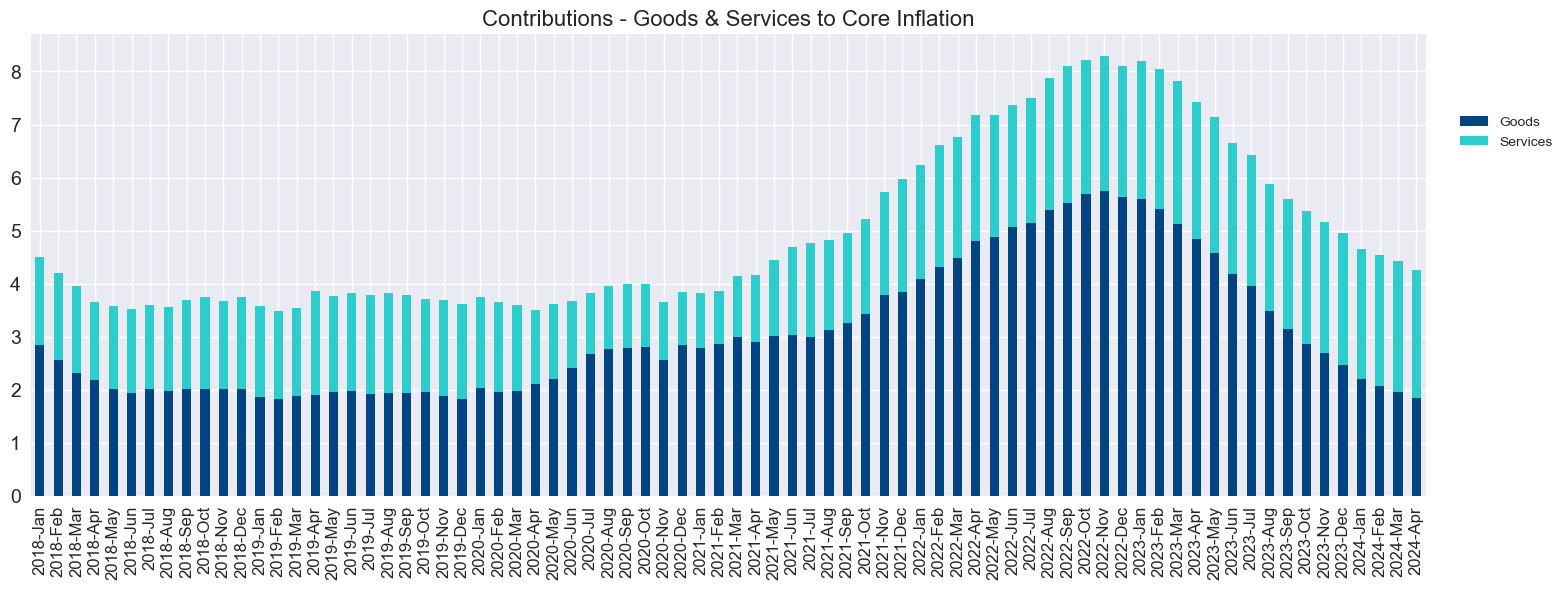

In [52]:
(total_core*100).plot.bar(stacked=True,figsize=(18,6),color=['#004481','#2DCCCD'])
plt.title('Contributions - Goods & Services to Core Inflation',size=16)
plt.legend(bbox_to_anchor=(1.1, 0.85))
plt.xticks(size=12)
plt.yticks(size=14)
plt.show()

### Goods Core Inflation - Food & Non Food

In [53]:
food=ponderadores['AlimentosBebidasTabaco_Mercancias_Subyacente']['IndiceGeneral']
nonfood=ponderadores['NoAlimenticias_Mercacias_Subyacente']['IndiceGeneral']

In [54]:
food_weight=food/100
nonfood_weight=nonfood/100

In [55]:
food_list=ponderadores[['INPC','AlimentosBebidasTabaco_Mercancias_Subyacente']][ponderadores['AlimentosBebidasTabaco_Mercancias_Subyacente']=='X']['INPC']
food_list_100=food_list/food_list.sum()
food_w_contribution=food_list_100 * food_weight

In [56]:
nonfood_list=ponderadores[['INPC','NoAlimenticias_Mercacias_Subyacente']][ponderadores['NoAlimenticias_Mercacias_Subyacente']=='X']['INPC']
nonfood_list_100=nonfood_list/nonfood_list.sum()
nonfood_w_contribution=nonfood_list_100 * nonfood_weight

In [57]:
YoY_change=finalData[food_list_100.index].pct_change(12)
food_contribution_goods=(YoY_change.loc['2018-Jan':] * food_w_contribution).sum(axis=1)

In [58]:
YoY_change=finalData[nonfood_list_100.index].pct_change(12)
nonfood_contribution_goods=(YoY_change.loc['2018-Jan':] * nonfood_w_contribution).sum(axis=1)

In [59]:
total_goods=pd.concat([food_contribution_goods,nonfood_contribution_goods],axis=1)

In [60]:
total_goods.columns=['Food','NonFood']

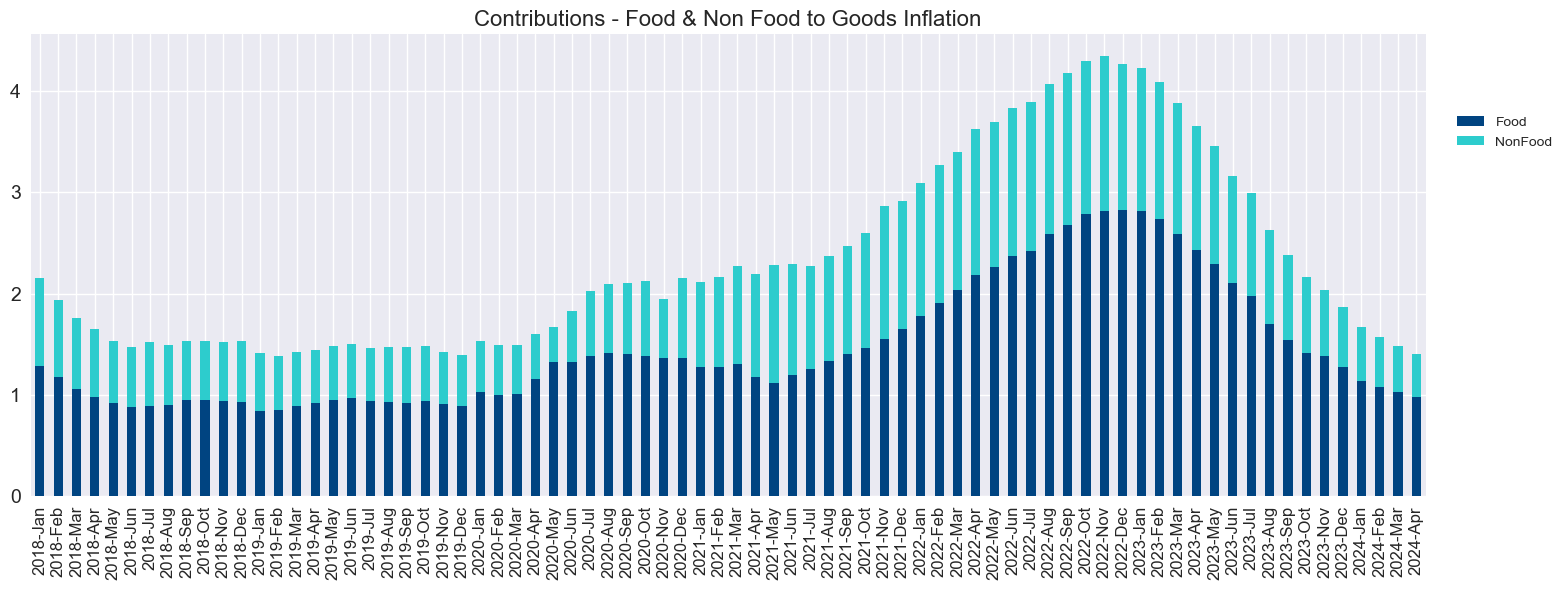

In [61]:
(total_goods*100).plot.bar(stacked=True,figsize=(18,6),color=['#004481','#2DCCCD'])
plt.title('Contributions - Food & Non Food to Goods Inflation',size=16)
plt.legend(bbox_to_anchor=(1.1, 0.85))
plt.xticks(size=12)
plt.yticks(size=14)
plt.show()

### Services Core Inflation - Components

In [62]:
education=ponderadores['Educacion_Servicios_Subyacente']['IndiceGeneral']
housing=ponderadores['Vivienda_Servicios_Subyacente']['IndiceGeneral']
others=ponderadores['Otros_Servicios_Subyacente']['IndiceGeneral']

In [63]:
education_weight=education/100
housing_weight=housing/100
others_weight=others/100

In [64]:
education_list=ponderadores[['INPC','Educacion_Servicios_Subyacente']][ponderadores['Educacion_Servicios_Subyacente']=='X']['INPC']
education_list_100=education_list/education_list.sum()
education_w_contribution=education_list_100 * education_weight

In [65]:
housing_list=ponderadores[['INPC','Vivienda_Servicios_Subyacente']][ponderadores['Vivienda_Servicios_Subyacente']=='X']['INPC']
housing_list_100=housing_list/housing_list.sum()
housing_w_contribution=housing_list_100 * housing_weight

In [66]:
others_list=ponderadores[['INPC','Otros_Servicios_Subyacente']][ponderadores['Otros_Servicios_Subyacente']=='X']['INPC']
others_list_100=food_list/others_list.sum()
others_w_contribution=others_list_100 * others_weight

In [67]:
YoY_change=finalData[education_list_100.index].pct_change(12)
education_contribution_services=(YoY_change.loc['2018-Jan':] * education_w_contribution).sum(axis=1)

In [68]:
YoY_change=finalData[housing_list_100.index].pct_change(12)
housing_contribution_services=(YoY_change.loc['2018-Jan':] * housing_w_contribution).sum(axis=1)

In [69]:
YoY_change=finalData[others_list_100.index].pct_change(12)
others_contribution_services=(YoY_change.loc['2018-Jan':] * others_w_contribution).sum(axis=1)

In [70]:
housing_contribution_services

2018-Jan    0.004246
2018-Feb    0.004160
2018-Mar    0.004126
2018-Apr    0.004152
2018-May    0.004131
              ...   
2023-Dec    0.006005
2024-Jan    0.005889
2024-Feb    0.005993
2024-Mar    0.006083
2024-Apr    0.006015
Length: 76, dtype: float64

In [71]:
total_services=pd.concat([education_contribution_services,housing_contribution_services,others_contribution_services],axis=1)

In [72]:
total_services.columns=['Education','Housing','Others']

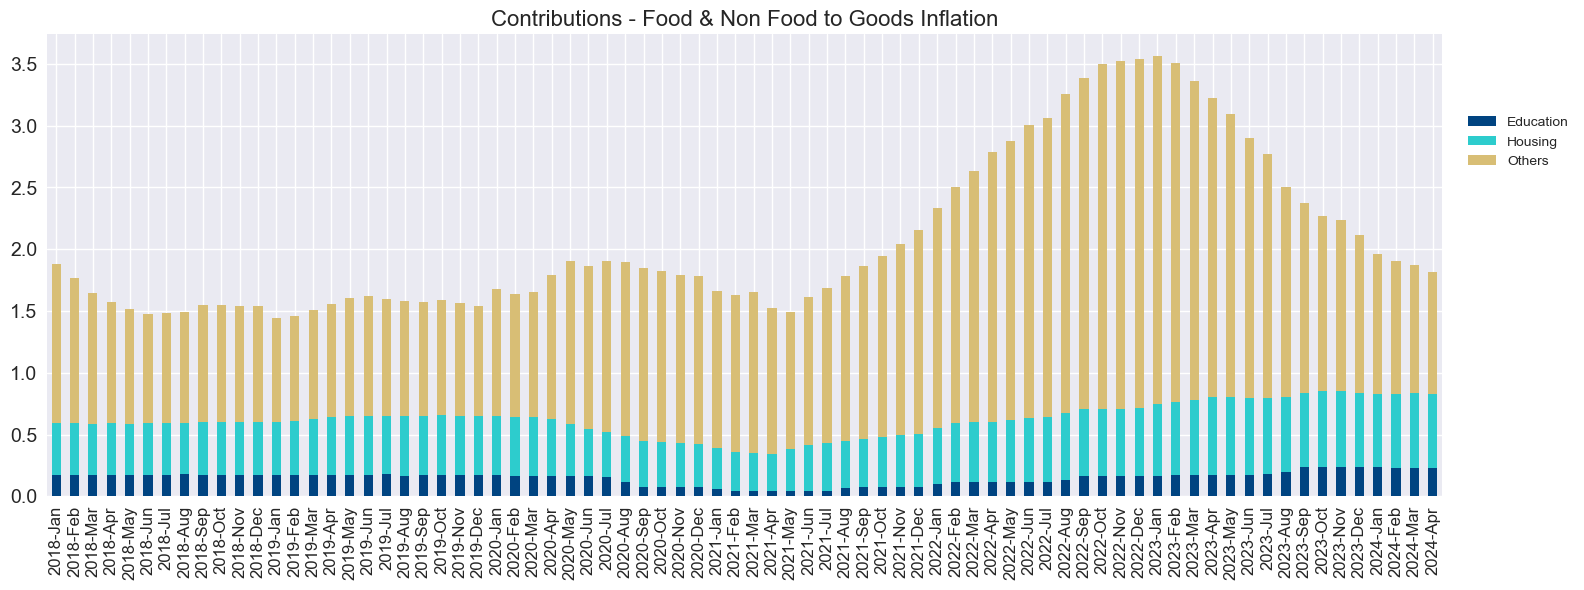

In [73]:
(total_services*100).plot.bar(stacked=True,figsize=(18,6),color=['#004481','#2DCCCD','#D8BE75'])
plt.title('Contributions - Food & Non Food to Goods Inflation',size=16)
plt.legend(bbox_to_anchor=(1.1, 0.85))
plt.xticks(size=12)
plt.yticks(size=14)
plt.show()

In [74]:
total=pd.concat([total_services,total_goods],axis=1)

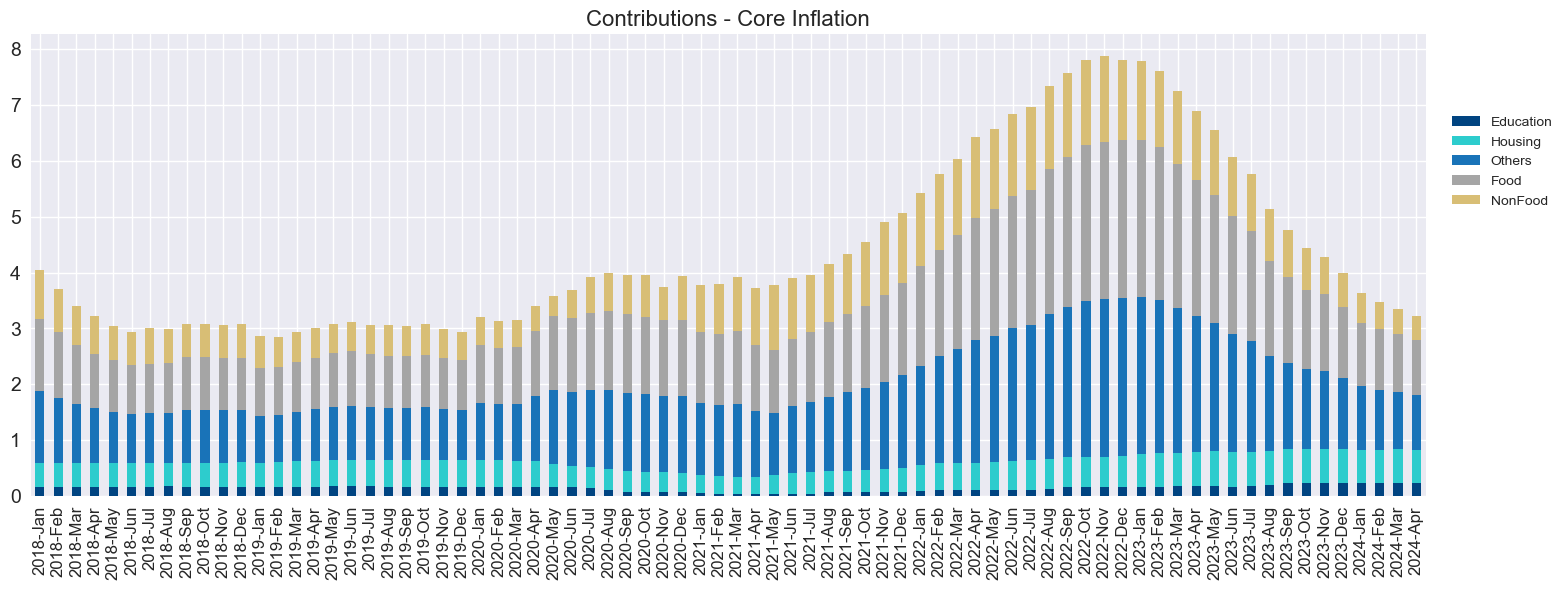

In [75]:
(total*100).plot.bar(stacked=True,figsize=(18,6),color=['#004481','#2DCCCD','#1973B8','#A5A5A5','#D8BE75'])
plt.title('Contributions - Core Inflation',size=16)
plt.legend(bbox_to_anchor=(1.1, 0.85))
plt.xticks(size=12)
plt.yticks(size=14)
plt.show()

### Distriution among ranges of change in total inflation

In [76]:
YoY_Changes=finalData.pct_change(12).loc['2018-Jan':]

In [77]:
def pct_proportion(data):
    results=pd.DataFrame()
    for i in data.index:
        line=data.loc[i].dropna()
        a=line[line < 0.02].count()
        b=line[(line>=0.02) & (line < 0.04)].count()
        c=line[(line>=0.04) & (line < 0.06)].count()
        d=line[(line>=0.06) & (line < 0.08)].count()
        e=line[line >= 0.08].count()
        proportions=(pd.DataFrame([a,b,c,d,e],columns=[i], index=['<2','2-4','4-6','6-8','>8'])/len(line.index))
        results=pd.concat([results,proportions],axis=1)
    return results

In [78]:
results=pct_proportion(YoY_Changes)

Text(0.5, 1.0, '% of Inflation Components among different YoY ranges')

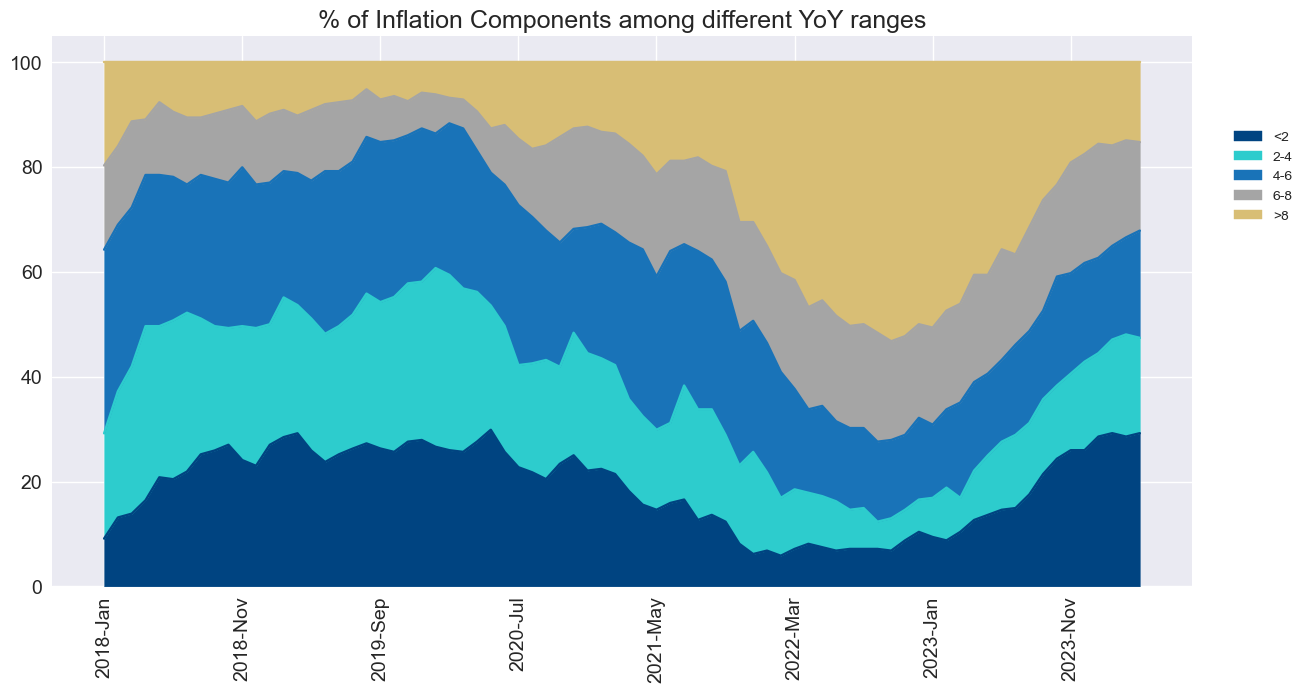

In [79]:
(results.T*100).plot.area(figsize=(12,6), stacked=True, color=['#004481','#2DCCCD','#1973B8','#A5A5A5','#D8BE75'])
plt.tight_layout(pad=1.0)
plt.legend(bbox_to_anchor=(1.1, 0.85))
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.title('% of Inflation Components among different YoY ranges', size=18)

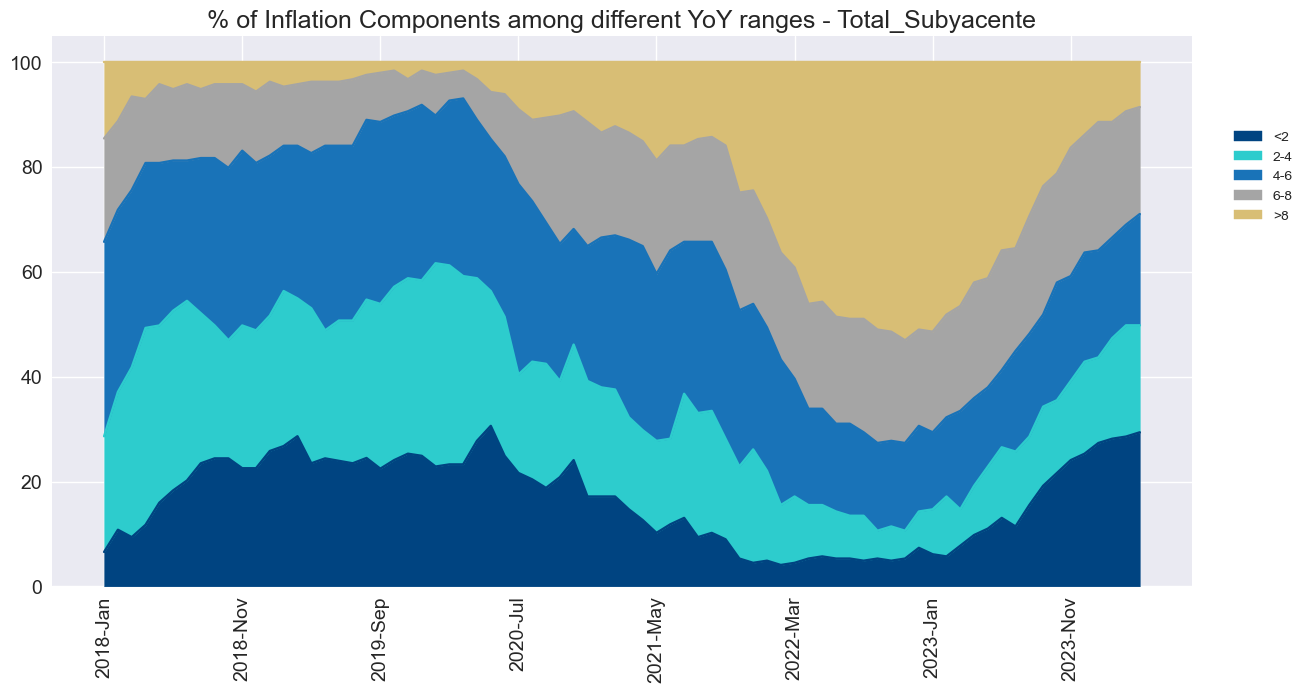

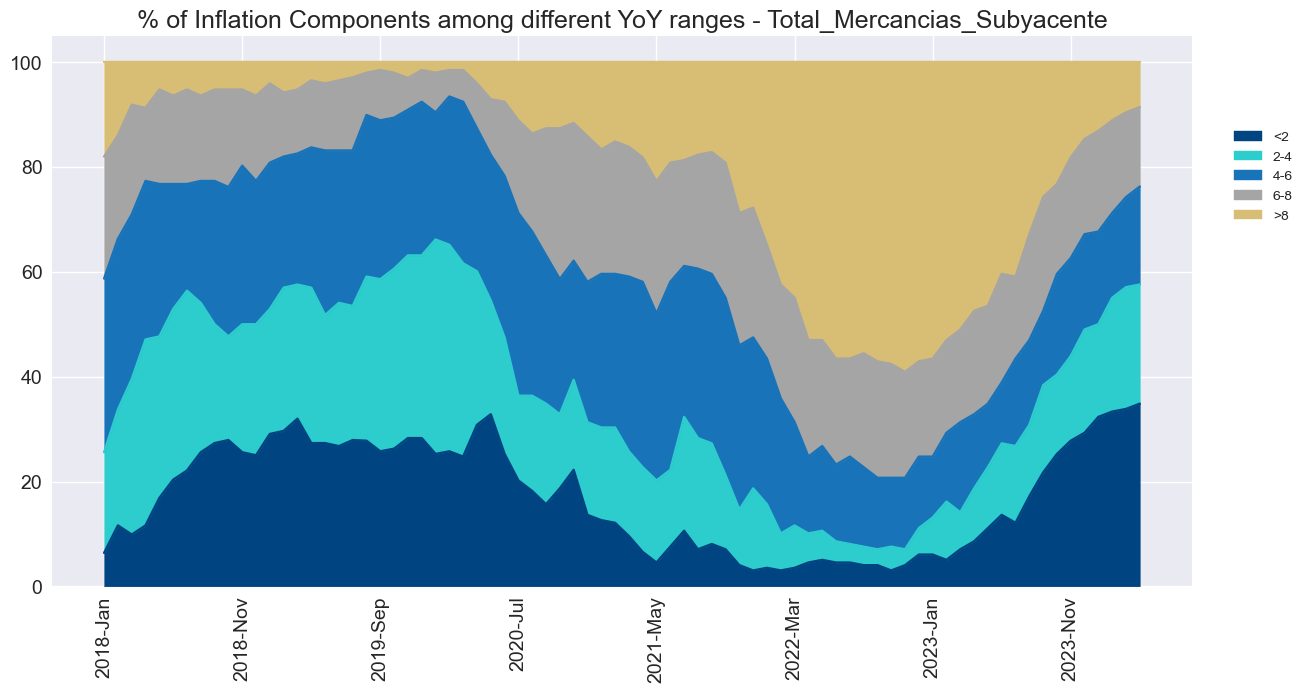

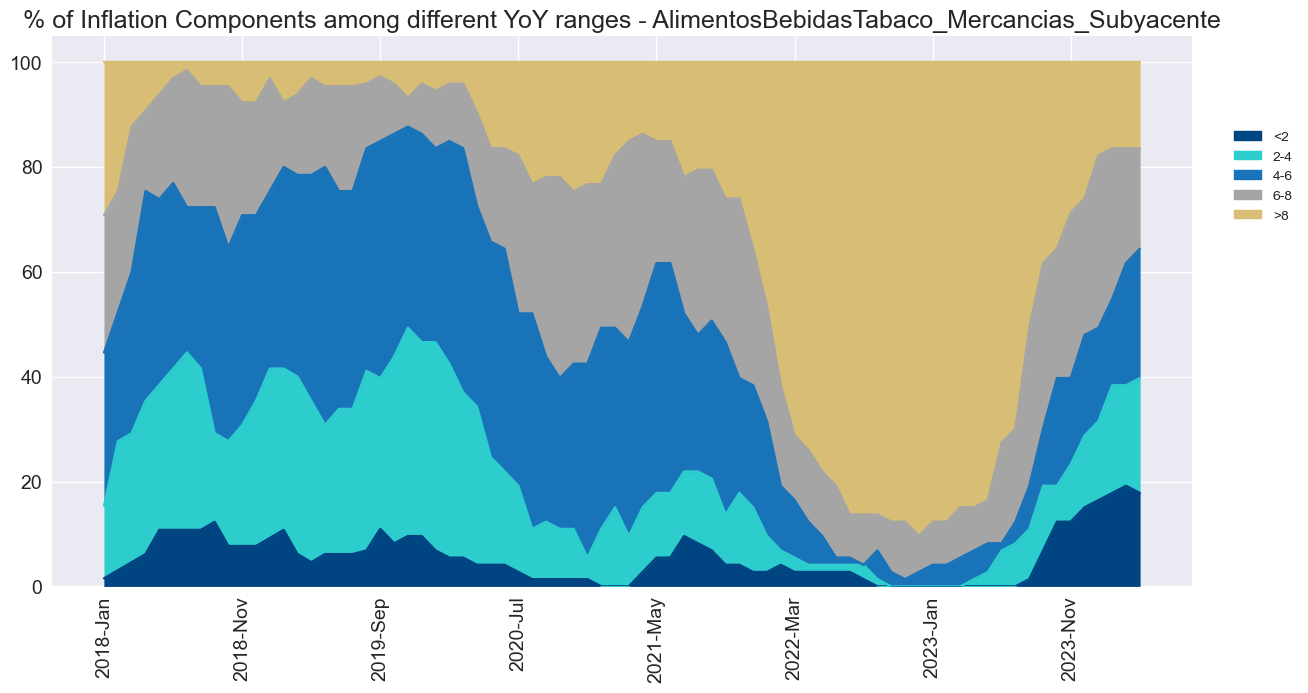

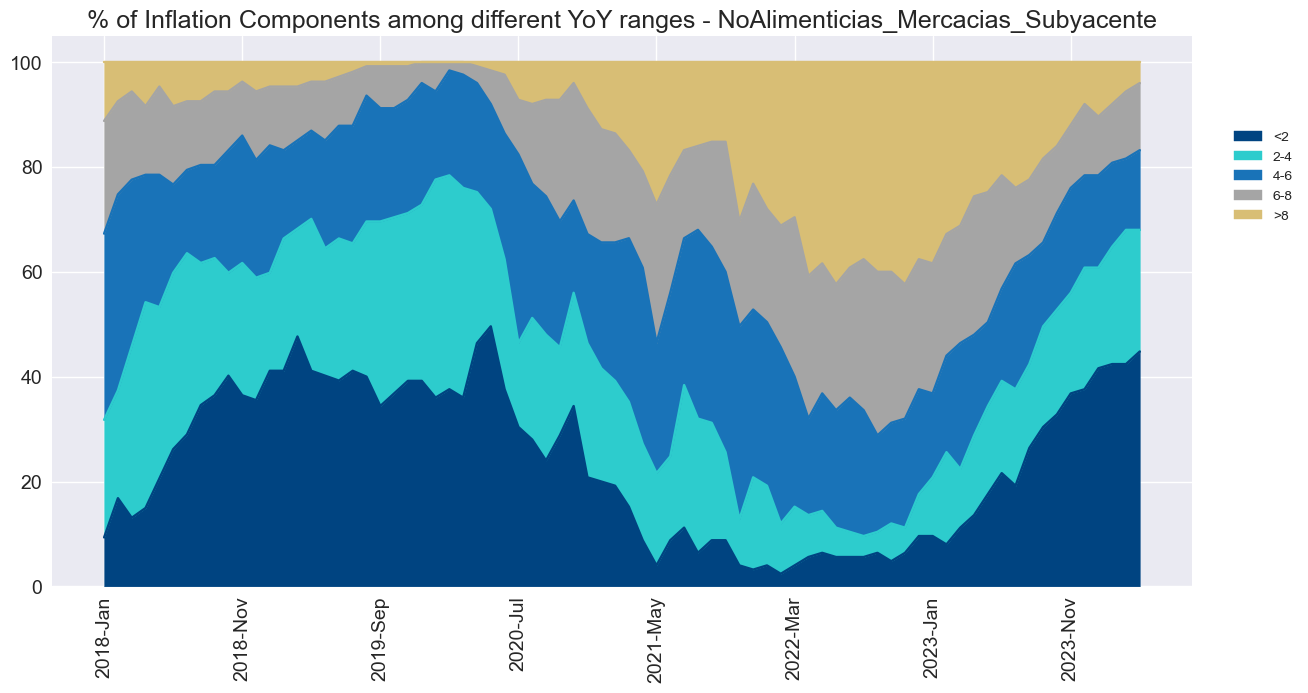

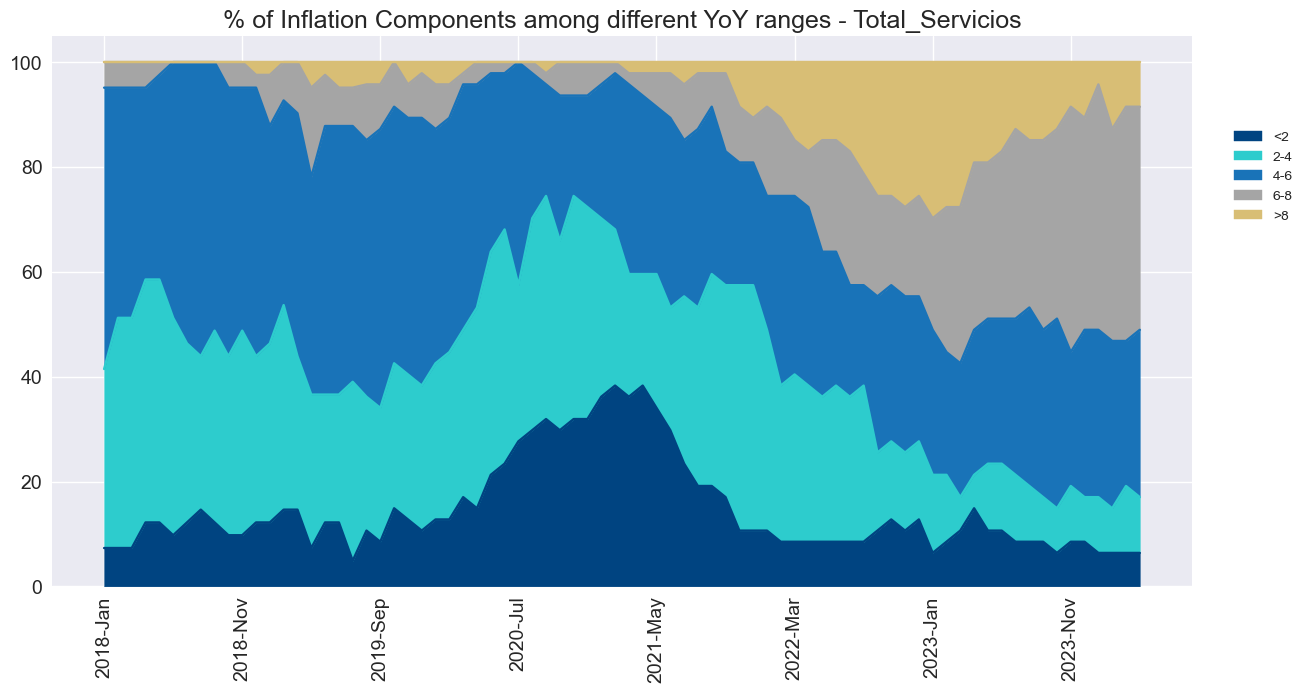

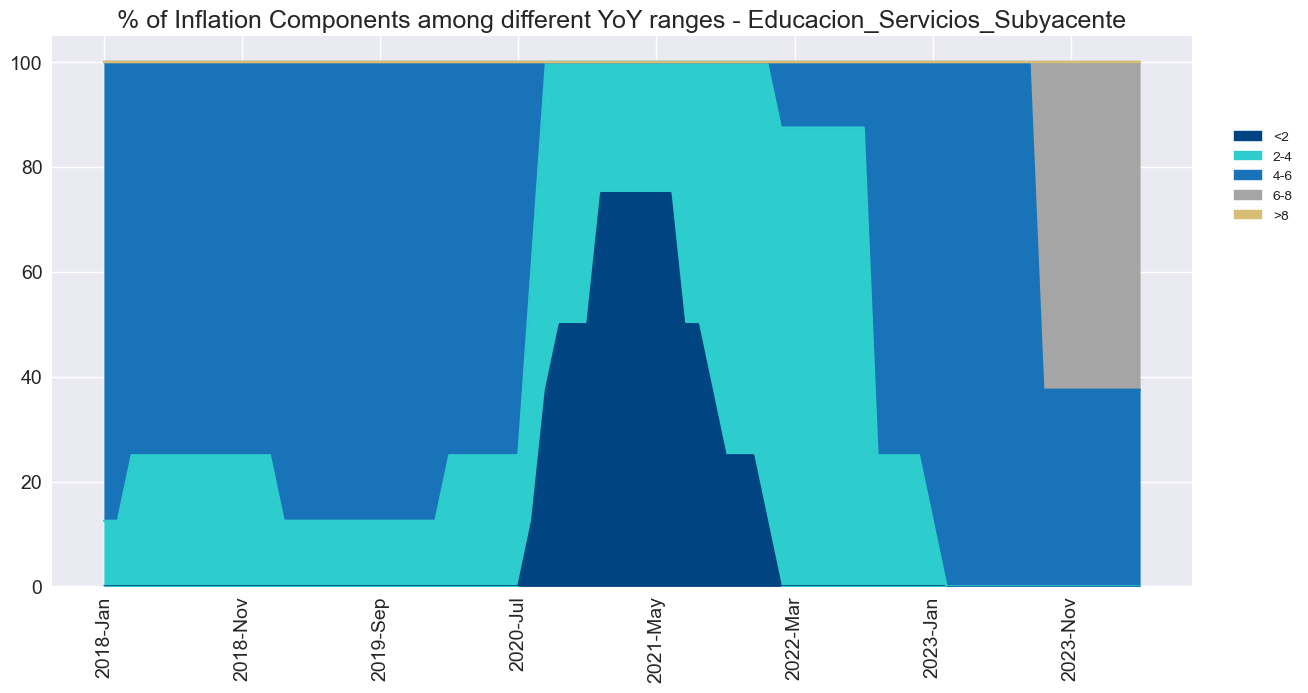

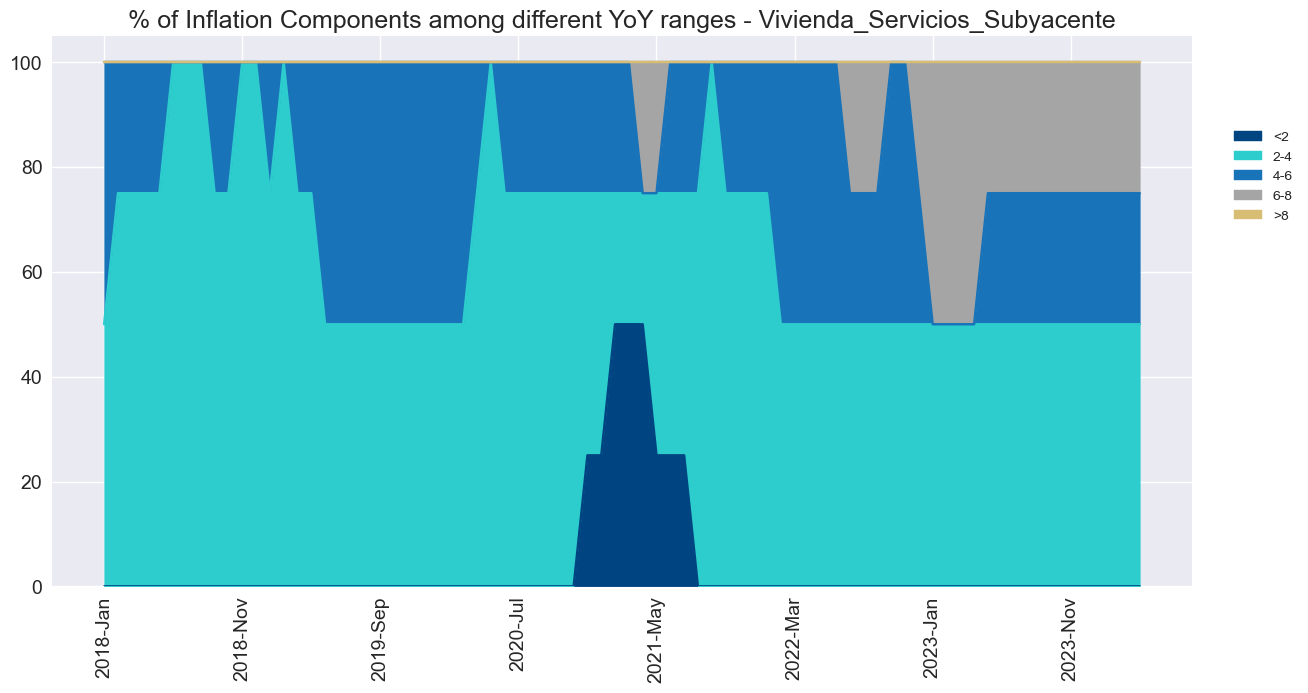

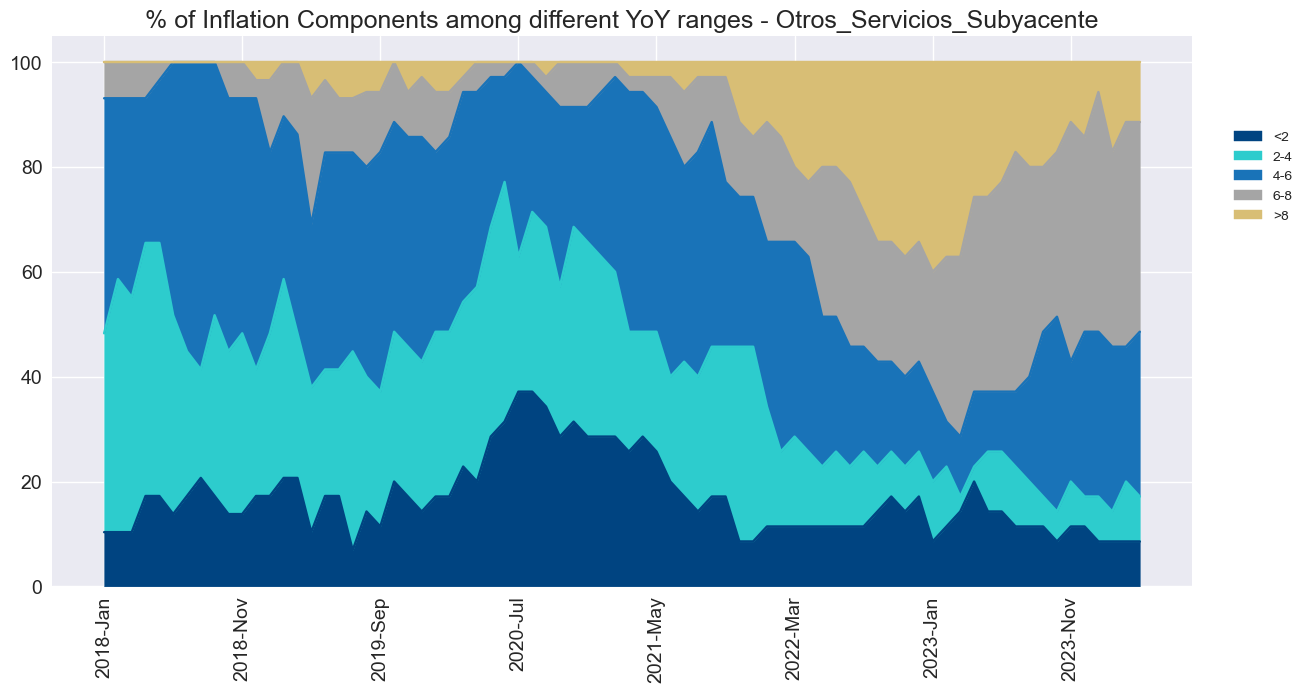

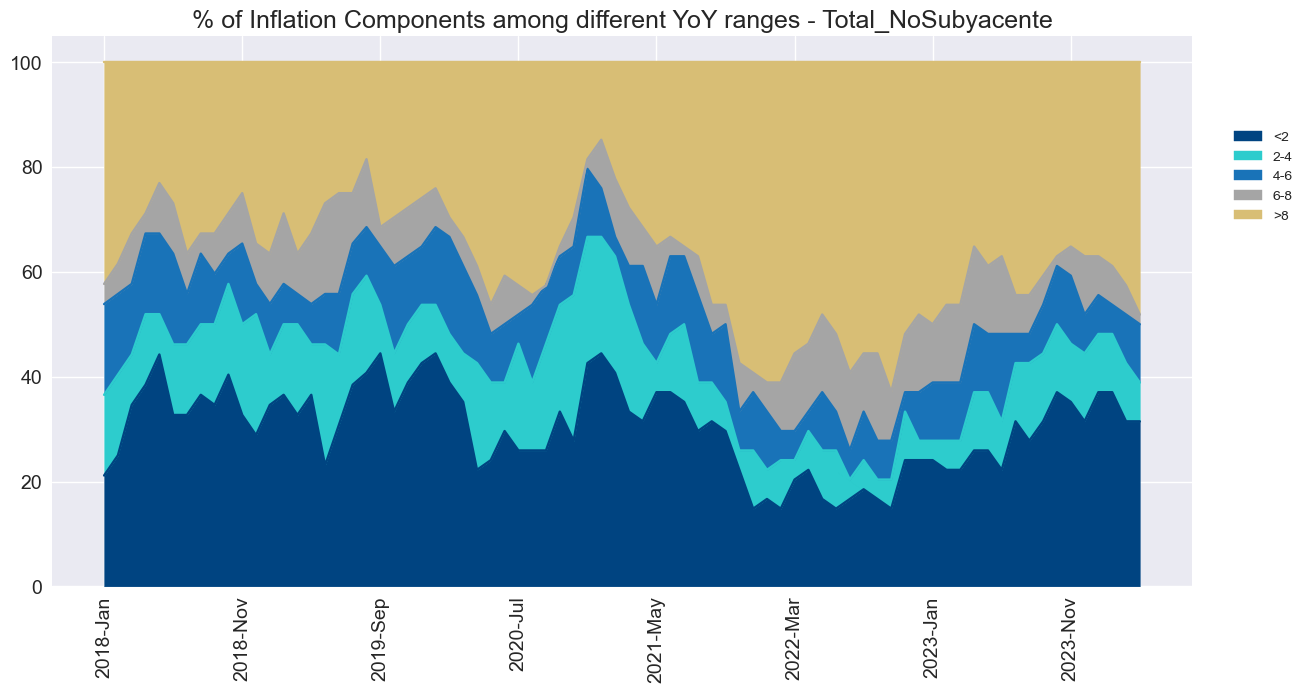

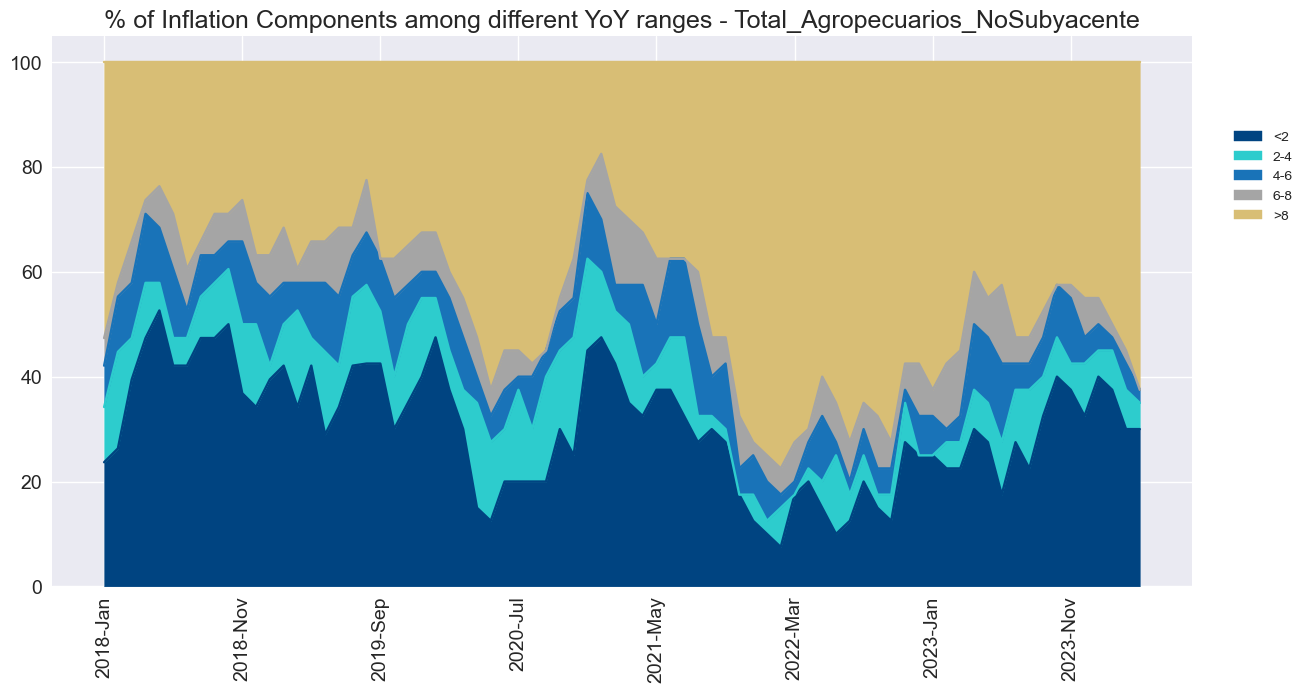

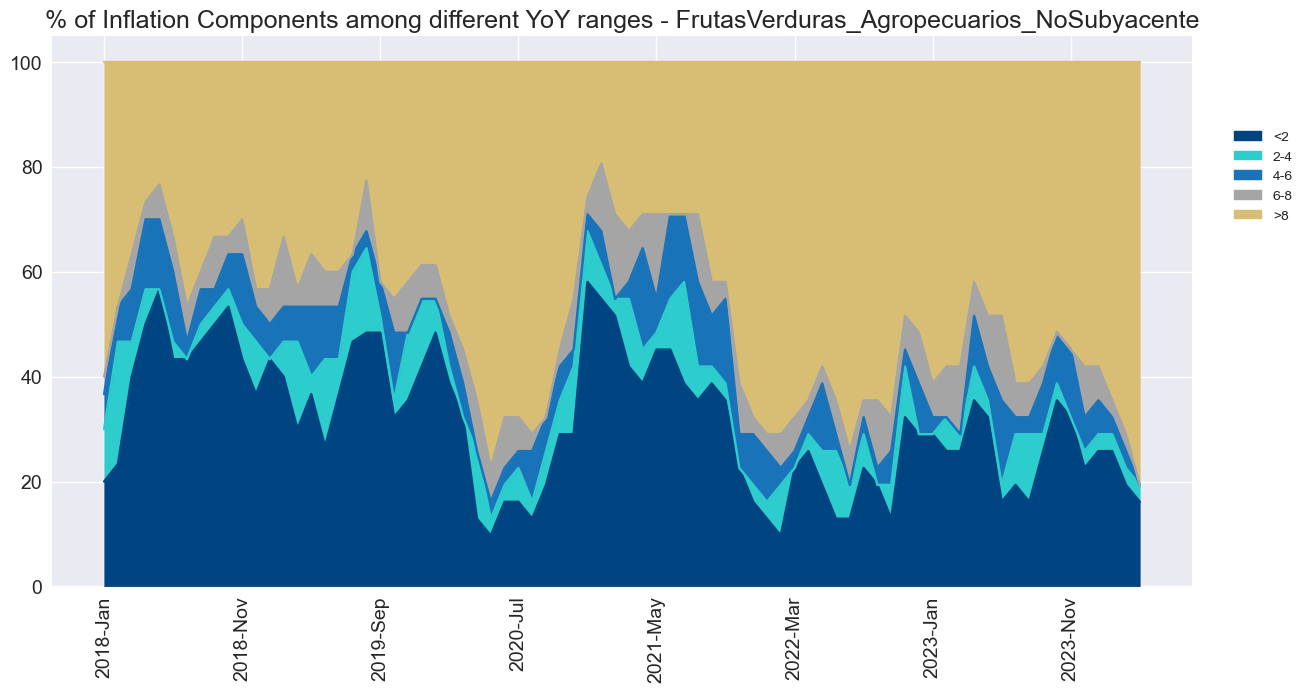

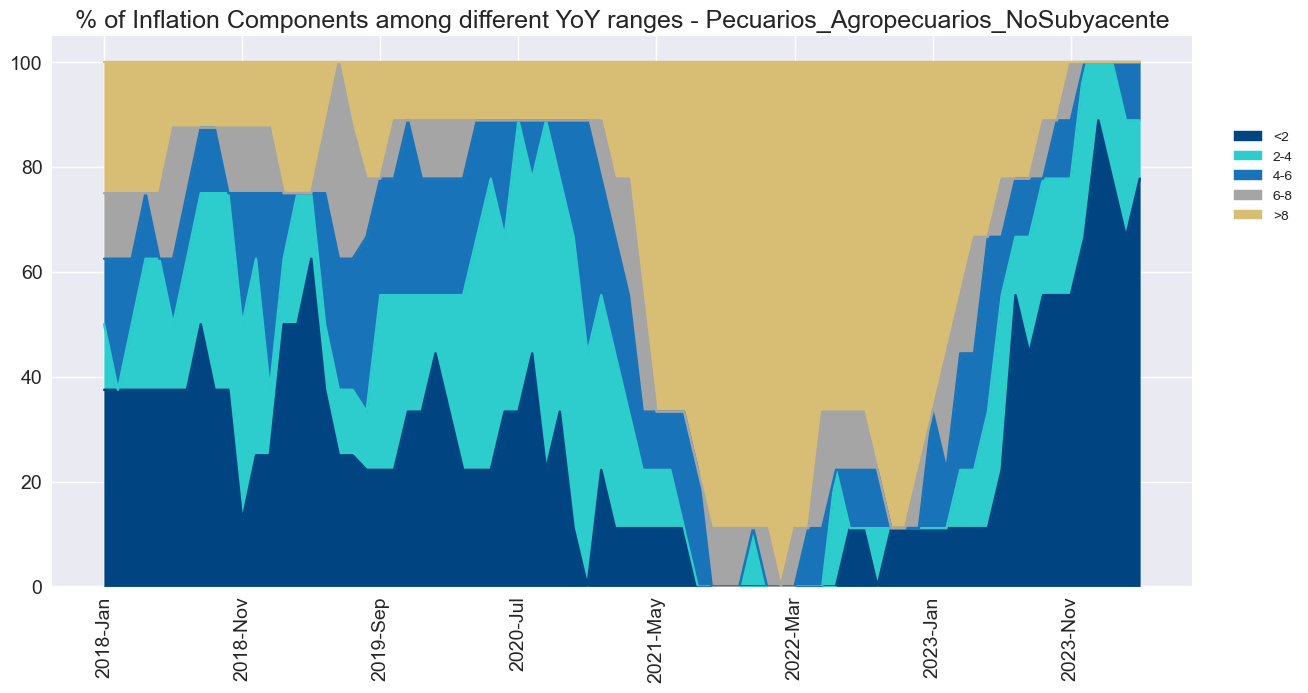

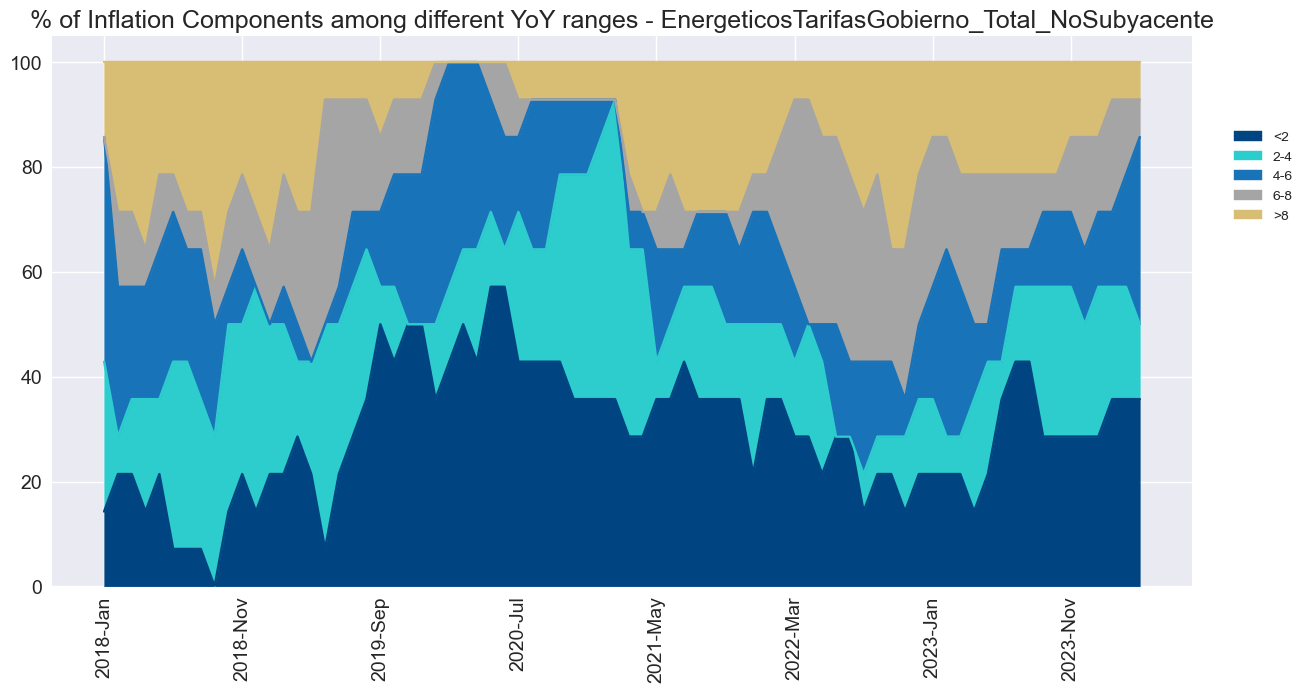

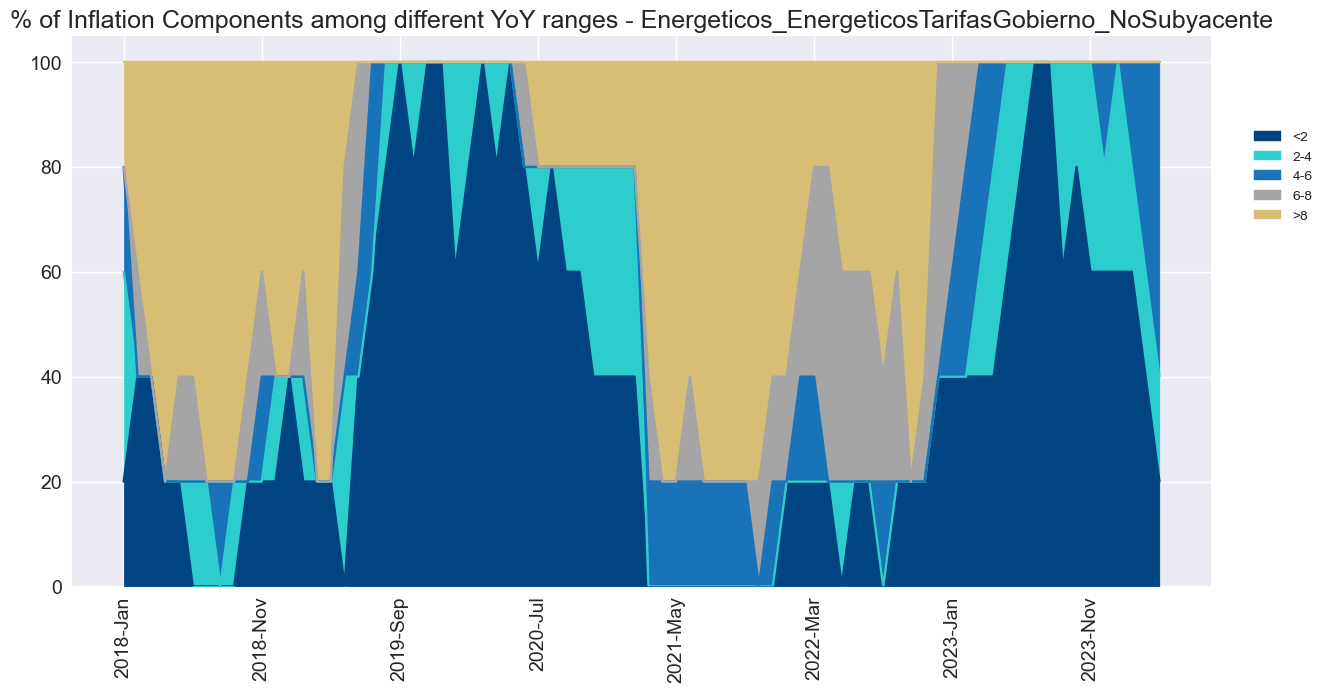

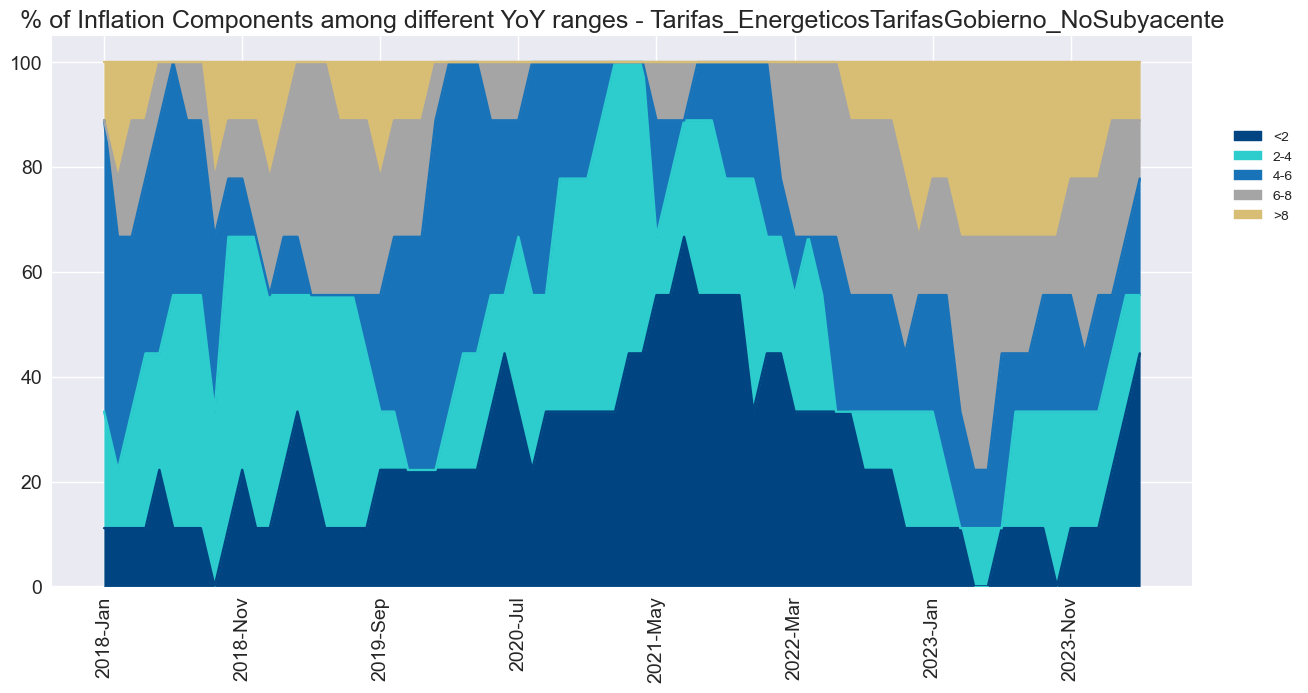

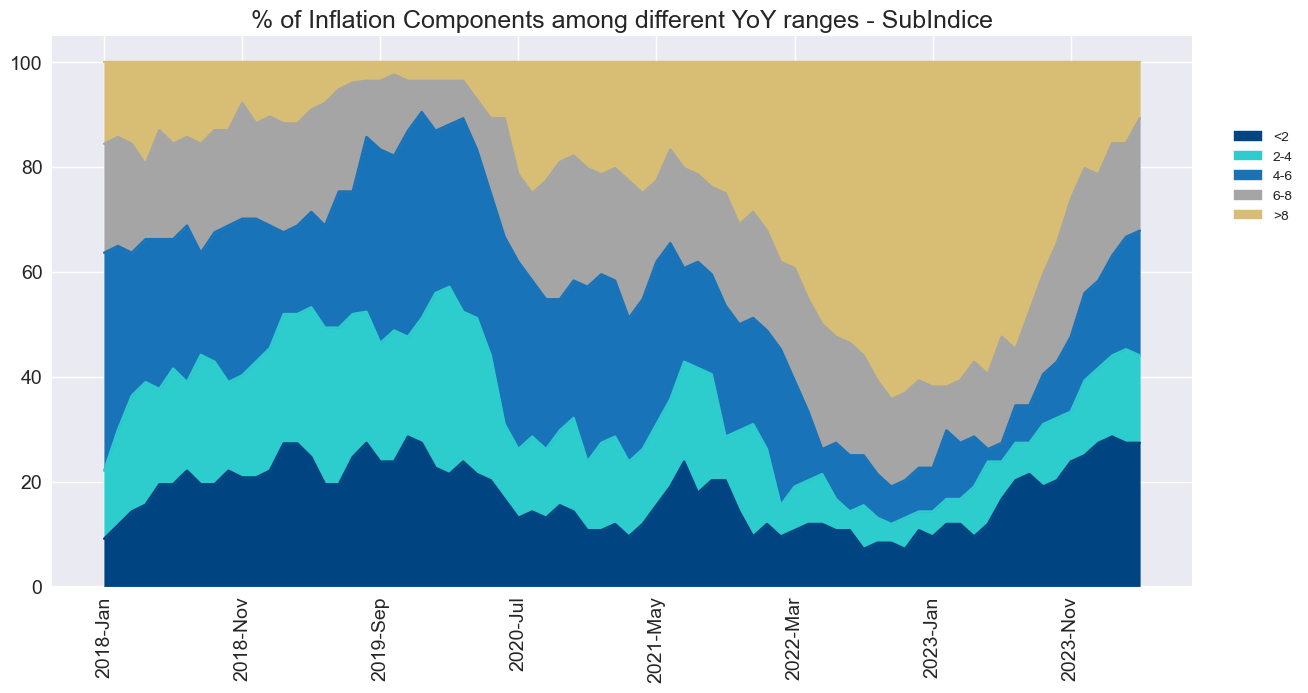

In [80]:
for key in list(ponderadores100.keys())[1:]:
    items=ponderadores100[key].index.to_list()
    YoY_Changes=finalData[items].pct_change(12).loc['2018-Jan':]
    results=pct_proportion(YoY_Changes)
    (results.T*100).plot.area(figsize=(12,6), stacked=True,color=['#004481','#2DCCCD','#1973B8','#A5A5A5','#D8BE75'])
    plt.tight_layout(pad=1.0)
    plt.legend(bbox_to_anchor=(1.1, 0.85))
    plt.xticks(rotation=90,size=14)
    plt.yticks(size=14)
    plt.title('% of Inflation Components among different YoY ranges - '+key, size=18)
    plt.show()

### EFECTO BASE

In [126]:
def identify_outliers_expanding_window(df, window=36, threshold=2):
    """
    Identify outliers in the last `window` data points of each column in the DataFrame using an expanding window approach.
    
    Args:
    df (pd.DataFrame): The input DataFrame.
    window (int): The number of recent data points to check for outliers.
    threshold (float): The z-score threshold to consider a data point as an outlier.
    
    Returns:
    pd.DataFrame: A DataFrame indicating which points in the last `window` are outliers for each column.
    """
    outliers_df = pd.DataFrame(index=df.index)

    for column in df.columns:
        if df[column].isna().any():
            print(f"Column '{column}' contains NA values and will be skipped.")
            continue
        
        outliers = pd.Series(index=df.index, dtype=bool)
        
        for i in range(1, window + 1):
            current_window = df[column][:-i]
            mean = current_window.mean()
            std = current_window.std()
            point = df[column].iloc[-i]
            z_score = (point - mean) / std
            outliers.iloc[-i] = np.abs(z_score) > threshold
        
        outliers_df[column] = outliers[-window:]

    return outliers_df

In [127]:
outliers=identify_outliers_expanding_window(YoY_Changes).dropna()

Column 'Chiles envasados' contains NA values and will be skipped.
Column 'Chocolate líquido y para preparar bebida' contains NA values and will be skipped.
Column 'Chocolate y productos de confitería' contains NA values and will be skipped.
Column 'Moles y salsas' contains NA values and will be skipped.
Column 'Servicios de telefonía fija' contains NA values and will be skipped.
Column 'Bicicletas' contains NA values and will be skipped.
Column 'Motocicletas' contains NA values and will be skipped.


<Axes: title={'center': 'Percentage of outliers in the mexican inflation componentes'}>

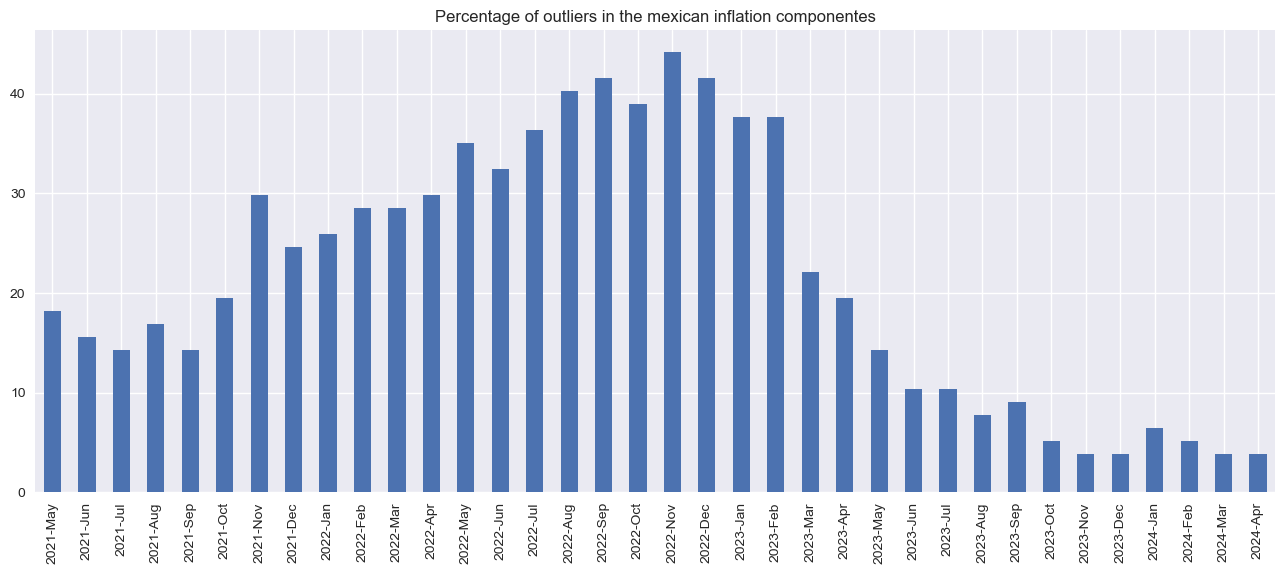

In [133]:
(outliers.sum(1)/len(outliers.columns)*100).plot(kind='bar',figsize=(16,6),title='Percentage of outliers in the mexican inflation componentes')

In [134]:
outliers

,Aceites y grasas vegetales comestibles,Agua embotellada,Arroz,Atún y sardina en lata,Azúcar,Café soluble,Café tostado,Carne de res,Cerveza,Concentrados de pollo y sal,...,Aceites lubricantes,Autobús foráneo,Autobús urbano,Colectivo,Gasolina de alto octanaje,Gasolina de bajo octanaje,Metro o transporte eléctrico,Taxi,Cine,Material escolar
2021-May,True,False,False,False,False,False,False,True,True,False,...,False,False,True,False,True,False,False,False,False,False
2021-Jun,True,False,False,False,False,False,False,True,True,False,...,False,False,True,False,False,False,False,False,False,False
2021-Jul,True,False,False,False,False,False,False,True,True,False,...,True,False,True,False,False,False,False,False,False,False
2021-Aug,True,False,False,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
2021-Sep,True,False,False,True,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
2021-Oct,True,False,False,True,False,False,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
2021-Nov,True,False,False,True,False,False,True,True,False,False,...,True,False,False,False,False,False,False,False,False,False
2021-Dec,True,False,False,True,False,False,True,True,False,False,...,True,False,False,False,False,False,False,False,False,False
2022-Jan,True,False,False,True,False,False,True,True,False,False,...,True,False,False,False,False,False,False,False,False,False
2022-Feb,True,False,False,True,False,False,True,True,False,False,...,True,False,False,False,False,False,False,False,False,False
